# Проект: Прогнозирование вероятности снижения активности клиента

**Описание проекта**

В рамках данного проекта требуется разработка аналитической модели, направленной на решение актуальной бизнес-задачи интернет-магазина «В один клик» — удержание постоянных клиентов в условиях снижающейся покупательской активности. Проект основан на методах бизнес-моделирования и анализа данных. Ключевой задачей является прогнозирование вероятности снижения активности клиента. Объединив полученные прогнозы с данными о прибыльности, мы проведем сегментацию покупателей и выделим целевые группы. Финальным этапом станет разработка персонализированных предложений, нацеленных на повышение лояльности и предотвращение оттока наиболее ценных клиентов.

**Цель исследования**

Цель проекта — разработать стратегию удержания ценных клиентов, находящихся в зоне риска, путем прогнозирования вероятности снижения их активности и последующей сегментации на основе этого прогноза и данных об их прибыльности.

**Ход исследования**

Для достижения поставленных целей будут выполнены следующие шаги:

- Первичный анализ и предобработка данных;
- Исследовательский анализ данных;
- Корреляционный анализ;
- Моделирование с помощью пайплайнов;
- Анализ важности признаков;
- Сегментация покупателей.

Также в заключительной части проекта будут сформулированы итоговые выводы и рекомендации для заказчика.

## Настройка среды

In [1]:
# устанавливаем библиотеки
!pip install phik -q
!pip install shap -q

In [2]:
# обновляем библиотеки
!pip install -U scikit-learn

In [3]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix
import shap

In [4]:
# импорт функций для МО
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score,
    recall_score, 
    precision_score, 
    accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)

# константа для фиксации случайных значений
RANDOM_STATE = 42
# размер тестовой выборки
TEST_SIZE = 0.25

## Ознакомление с данными

In [5]:
# сохраняем датасеты в переменные
customers_data = pd.read_csv('market_file.csv') # инфо о покупателях
revenue_data = pd.read_csv('market_money.csv') # инфо о выручке с каждого покупателя
web_time_data = pd.read_csv('market_time.csv') # инфо о времени на сайте (в минутах)
profit_data = pd.read_csv('money.csv', sep=';', decimal=',') # инфо о прибыли продавца за 3 месяца

### Данные о покупателях (customers_data)

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [6]:
# ознакомление с датасетом
customers_data.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [7]:
# общая информация о данных
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
# размерность таблицы
customers_data.shape

(1300, 13)

In [9]:
# статистическое описание данных
customers_data.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


### Данные о выручке с каждого покупателя (revenue_data)

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [10]:
# ознакомление с датасетом
revenue_data.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [11]:
# общая информация о данных
revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
# размерность таблицы
revenue_data.shape

(3900, 3)

In [13]:
# статистическое описание данных
revenue_data.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


### Данные о времени, проведенном на сайте (web_time_data)

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [14]:
# ознакомление с датасетом
web_time_data.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [15]:
# общая информация о данных
web_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [16]:
# размерность таблицы
web_time_data.shape

(2600, 3)

In [17]:
# статистическое описание данных
web_time_data.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


### Данные о прибыли продавца за последние 3 месяца (profit_data)

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [18]:
# ознакомление с датасетом
profit_data.head(10)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


In [19]:
# общая информация о данных
profit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [20]:
# размерность таблицы
profit_data.shape

(1300, 2)

In [21]:
# статистическое описание данных
profit_data.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


<div style="border: 2px solid black; padding: 10px;">
  <strong>На этапе предобработки требуется:</strong>
  <ul> 
    <li>Изменить названия столбцов;</li>
    <li>Проверить датафреймы на наличие явных и неявных дубликатов и устранить их;</li> 
    <li>Проверить датафреймы на наличие пропусков и устранить их;</li>
    <li>Повторно проверить тип данных столбцов;</li> 
    <li>Проверить данные на наличие ошибок и устранить их;</li>   
      
  После предобработки данные будут пригодны для дальнейшего анализа.  
  </ul>
</div>

## Предобработка данных

### Изменение названий столбцов

Для удобства при работе с данными изменим названия столбцов:

#### customers_data

In [22]:
# для удобства переименуем столбцы
customers_data.rename(columns={
    'Покупательская активность': 'purchasing_activity',
    'Тип сервиса': 'service_type',
    'Разрешить сообщать': 'allow_promos',
    'Маркет_актив_6_мес': 'marketing_avg',
    'Маркет_актив_тек_мес': 'marketing_current',
    'Длительность': 'days_since_signup',
    'Акционные_покупки': 'promo_share',
    'Популярная_категория': 'top_category',
    'Средний_просмотр_категорий_за_визит': 'avg_category_views',
    'Неоплаченные_продукты_штук_квартал': 'unpaid_items_q',
    'Ошибка_сервиса': 'service_errors',
    'Страниц_за_визит': 'pages_per_visit'
}, inplace=True)

# ознакомление с датасетом после изменений
customers_data.head(1)

,id,purchasing_activity,service_type,allow_promos,marketing_avg,marketing_current,days_since_signup,promo_share,top_category,avg_category_views,unpaid_items_q,service_errors,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


*Описание данных*

- **id** - номер покупателя в корпоративной базе данных.
- **purchasing_activity** - рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- **service_type** - уровень сервиса, например «премиум» и «стандарт».
- **allow_promos** - информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- **marketing_avg** - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- **marketing_current** - количество маркетинговых коммуникаций в текущем месяце.
- **days_since_signup** - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- **promo_share** - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- **top_category** - самая популярная категория товаров у покупателя за последние 6 месяцев.
- **avg_category_views** - показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- **unpaid_items_q** - общее число неоплаченных товаров в корзине за последние 3 месяца.
- **service_errors** - число сбоев, которые коснулись покупателя во время посещения сайта.
- **pages_per_visit** - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

#### revenue_data

In [23]:
# для удобства переименуем столбцы
revenue_data.rename(columns={
    'Период': 'period',
    'Выручка': 'revenue'
}, inplace=True)

# ознакомление с датасетом после изменений
revenue_data.head(1)

,id,period,revenue
0,215348,препредыдущий_месяц,0.0


**Описание данных**

- **id** - номер покупателя в корпоративной базе данных.
- **period** - название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- **revenue** - сумма выручки за период.

#### web_time_data

In [24]:
# для удобства переименуем столбцы
web_time_data.rename(columns={
    'Период': 'period',
    'минут': 'minutes_online'
}, inplace=True)

# ознакомление с датасетом после изменений
web_time_data.head(1)

,id,period,minutes_online
0,215348,текущий_месяц,14


**Описание данных**

- **id** - номер покупателя в корпоративной базе данных.
- **period** - название периода, во время которого зафиксировано общее время.
- **minutes_online** - значение времени, проведённого на сайте, в минутах.

#### profit_data

In [25]:
# для удобства переименуем столбцы
profit_data.rename(columns={
    'Прибыль': 'profit'
}, inplace=True)

# ознакомление с датасетом после изменений
profit_data.head(1)

,id,profit
0,215348,0.98


**Описание данных**

- **id** - номер покупателя в корпоративной базе данных.
- **profit** - значение прибыли.

### Обработка дубликатов

Сначала проверим датасет на наличие неявных дубликатов в строковых столбцах, после чего обработаем явные дубликаты.

In [26]:
# категориальные столбцы
cat_columns = ['purchasing_activity', 'service_type', 'allow_promos', 'top_category', 'period']

# словарь датафреймов
dataframes = {
    "customers_data": customers_data,
    "revenue_data": revenue_data,
    "web_time_data": web_time_data
}

# проверим уникальные значения некоторых столбцов
for name, df in dataframes.items():
    print(f'Уникальные значения в столбцах {name}:')
    for category in cat_columns:
        if category in df.columns:
            print(f'{category}: {df[category].dropna().sort_values().unique()}')
    print()

Уникальные значения в столбцах customers_data:
purchasing_activity: ['Прежний уровень' 'Снизилась']
service_type: ['премиум' 'стандарт' 'стандартт']
allow_promos: ['да' 'нет']
top_category: ['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']

Уникальные значения в столбцах revenue_data:
period: ['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц']

Уникальные значения в столбцах web_time_data:
period: ['предыдцщий_месяц' 'текущий_месяц']



В некоторых столбцах присутствуют неявные дубликаты и ошибки. Исправим это:

In [27]:
# заменяем неявные дубликаты и ошибки на корректные значения
customers_data['purchasing_activity'] = customers_data['purchasing_activity'].replace('Прежний уровень', 'прежний_уровень')
customers_data['purchasing_activity'] = customers_data['purchasing_activity'].replace('Снизилась', 'снижение')
customers_data['service_type'] = customers_data['service_type'].replace('стандартт', 'стандарт')
customers_data['top_category'] = customers_data['top_category'].replace('Косметика и аксесуары', 'Косметика и аксессуары')
revenue_data['period'] = revenue_data['period'].replace('предыдущий_месяц', 'прошлый_месяц')
revenue_data['period'] = revenue_data['period'].replace('препредыдущий_месяц', 'позапрошлый_месяц')
web_time_data['period'] = web_time_data['period'].replace('предыдцщий_месяц', 'прошлый_месяц')

# еще раз проверим уникальные значения столбцов
for name, df in dataframes.items():
    print(f'Уникальные значения в столбцах {name}:')
    for category in cat_columns:
        if category in df.columns:
            print(f'{category}: {df[category].dropna().sort_values().unique()}')
    print()

Уникальные значения в столбцах customers_data:
purchasing_activity: ['прежний_уровень' 'снижение']
service_type: ['премиум' 'стандарт']
allow_promos: ['да' 'нет']
top_category: ['Домашний текстиль' 'Косметика и аксессуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']

Уникальные значения в столбцах revenue_data:
period: ['позапрошлый_месяц' 'прошлый_месяц' 'текущий_месяц']

Уникальные значения в столбцах web_time_data:
period: ['прошлый_месяц' 'текущий_месяц']



Теперь проверим датафреймы на наличие явных дубликатов:

In [28]:
# проверяем данные на наличие явных дубликатов
print(f"Количество явных дубликатов в customers_data: {customers_data.duplicated().sum()}")
print(f"Количество явных дубликатов в revenue_data: {revenue_data.duplicated().sum()}")
print(f"Количество явных дубликатов в web_time_data: {web_time_data.duplicated().sum()}")
print(f"Количество явных дубликатов в profit_data: {profit_data.duplicated().sum()}")

Количество явных дубликатов в customers_data: 0
Количество явных дубликатов в revenue_data: 0
Количество явных дубликатов в web_time_data: 0
Количество явных дубликатов в profit_data: 0


Явные дубликаты отсутствуют.

### Обработка пропусков

Проверим датафреймы на наличие пропусков:

In [29]:
# проверяем количество пропусков в данных
customers_data.isna().sum()

id                     0
purchasing_activity    0
service_type           0
allow_promos           0
marketing_avg          0
marketing_current      0
days_since_signup      0
promo_share            0
top_category           0
avg_category_views     0
unpaid_items_q         0
service_errors         0
pages_per_visit        0
dtype: int64

In [30]:
revenue_data.isna().sum()

id         0
period     0
revenue    0
dtype: int64

In [31]:
web_time_data.isna().sum()

id                0
period            0
minutes_online    0
dtype: int64

In [32]:
profit_data.isna().sum()

id        0
profit    0
dtype: int64

Пропуски отсутствуют.

### Изменение типов данных

Проверим, корректны ли типы данных:

In [33]:
# проверяем типы данных
customers_data.dtypes

id                       int64
purchasing_activity     object
service_type            object
allow_promos            object
marketing_avg          float64
marketing_current        int64
days_since_signup        int64
promo_share            float64
top_category            object
avg_category_views       int64
unpaid_items_q           int64
service_errors           int64
pages_per_visit          int64
dtype: object

In [34]:
revenue_data.dtypes

id           int64
period      object
revenue    float64
dtype: object

In [35]:
web_time_data.dtypes

id                 int64
period            object
minutes_online     int64
dtype: object

In [36]:
profit_data.dtypes

id          int64
profit    float64
dtype: object

Все корректно, изменение типов данных не требуется.

<div style="border: 2px solid black; padding: 10px;">
  <strong>Итоги:</strong>
  <ul>
    <li>Изменены названия столбцов в датасетах;</li>
    <li>Устранены неявные дубликаты в категориальных столбцах;</li>   
    <li>Пропуски в данных отсутствуют;</li> 
    <li>Изменение типов данных не требуется.</li> 

  Теперь данные готовы к исследовательскому анализу.  
  </ul>
</div>

## Исследовательский анализ данных

На данном этапе мы проведем статистический анализ всех признаков, а также построим графики для каждого из них с учетом того, что количественным и категориальным данным подходят разные способы визуализации. Это поможет заметить выбросы, необычное распределение количественных признаков и другие особенности с целью улучшить данные и подготовить их к моделированию.

### customers_data

Для удобства разделим исследуемые признаки на количественные и категориальные:

In [37]:
# разделим признаки
num_cols = customers_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = customers_data.select_dtypes(include=['object']).columns.tolist()

print("Количественные признаки:", num_cols)
print("Категориальные признаки:", cat_cols)

Количественные признаки: ['id', 'marketing_avg', 'marketing_current', 'days_since_signup', 'promo_share', 'avg_category_views', 'unpaid_items_q', 'service_errors', 'pages_per_visit']
Категориальные признаки: ['purchasing_activity', 'service_type', 'allow_promos', 'top_category']


Начнем с исследования количественных признаков:

In [38]:
# статистическое описание количественных признаков
customers_data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
marketing_avg,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
marketing_current,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
days_since_signup,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
promo_share,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
avg_category_views,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
unpaid_items_q,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
service_errors,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
pages_per_visit,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


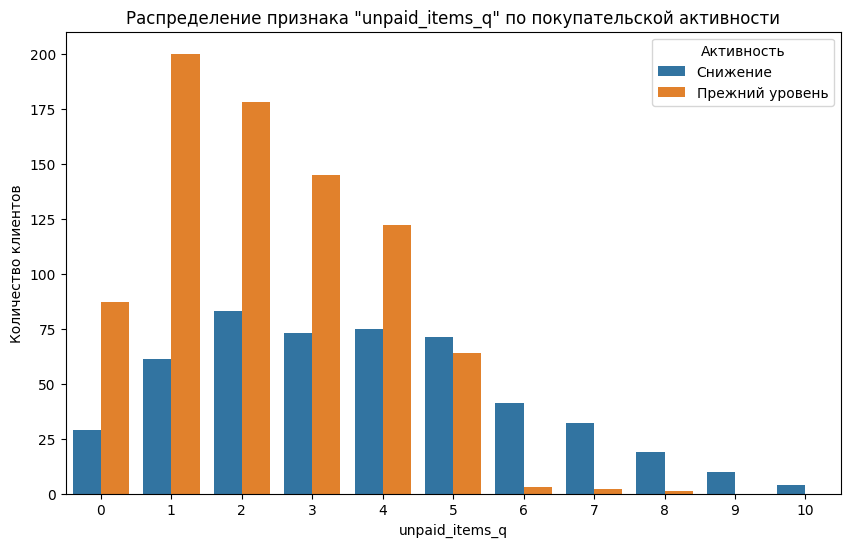

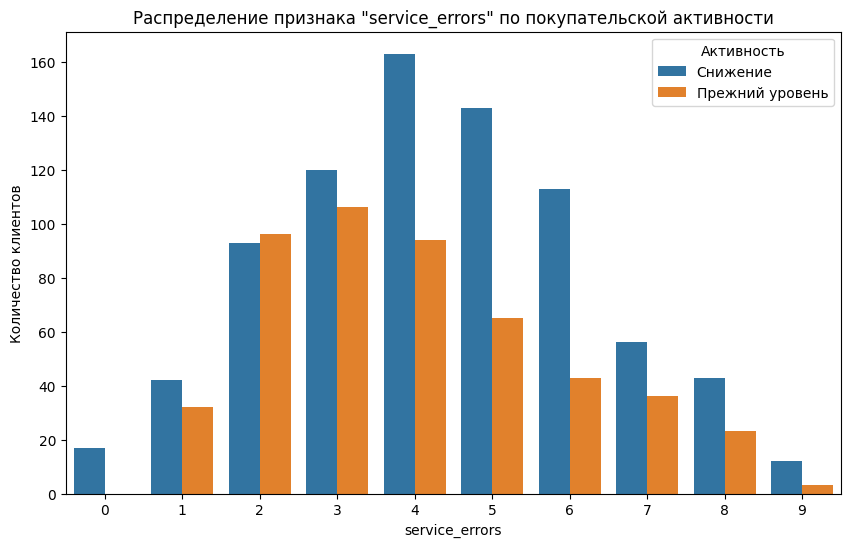

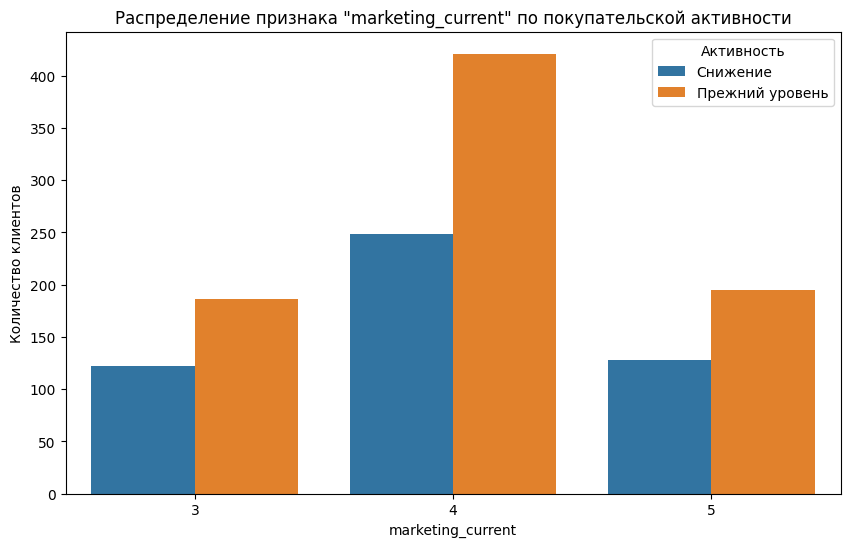

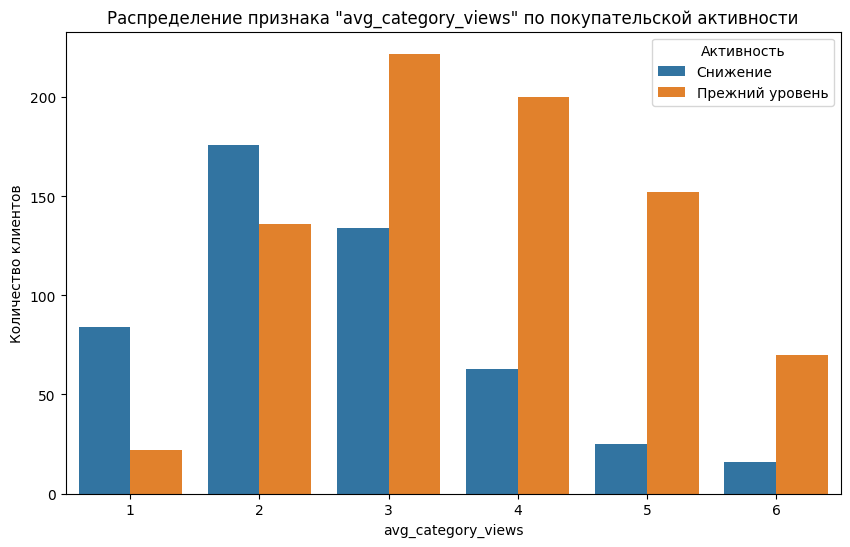

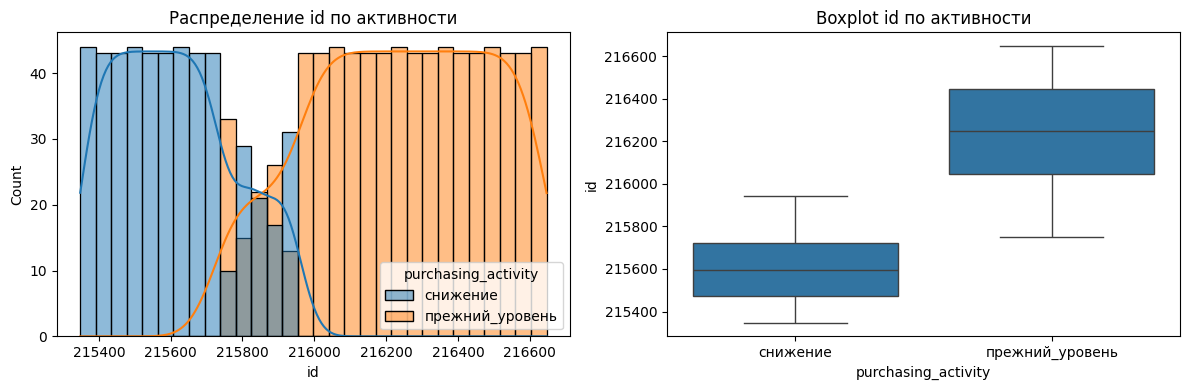

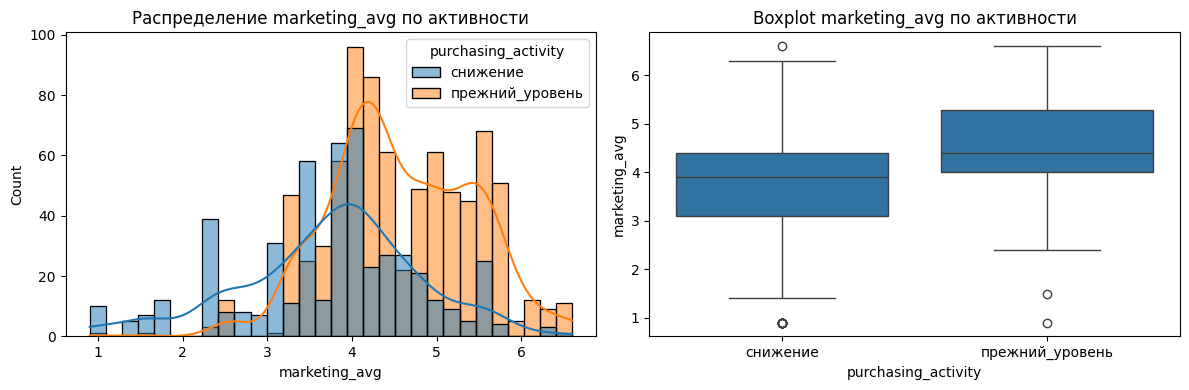

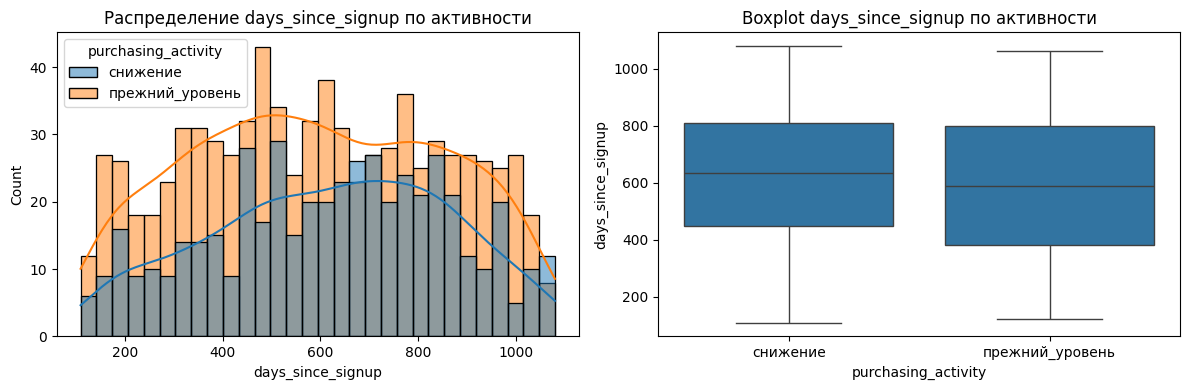

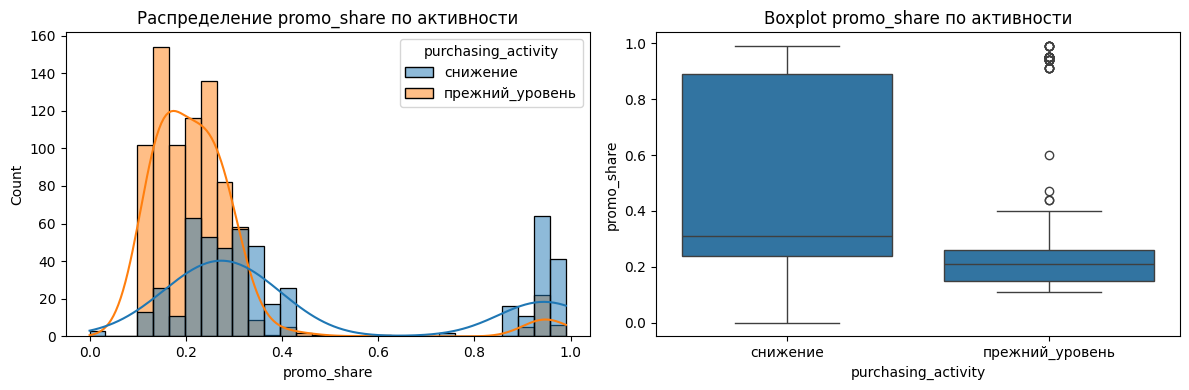

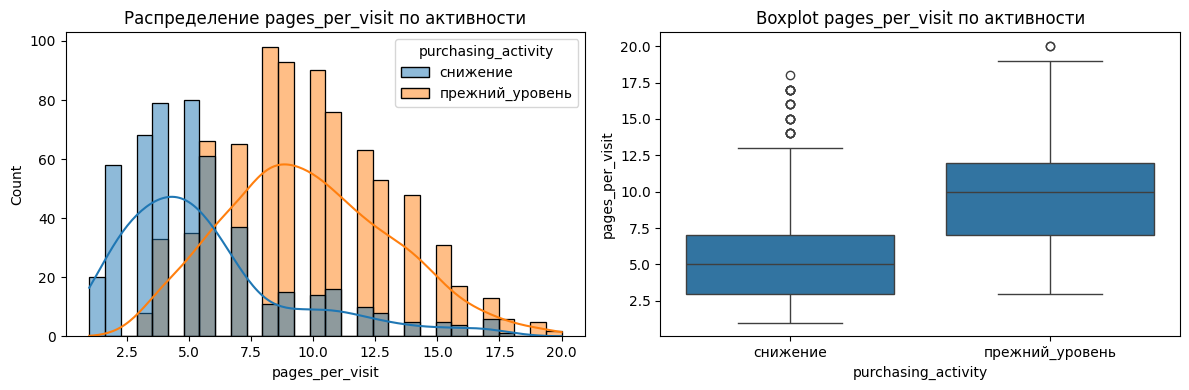

In [39]:
# разделяем признаки на дискретные и непрерывные
discrete_cols = ['unpaid_items_q', 'service_errors', 'marketing_current', 'avg_category_views']
continuous_cols = ['id', 'marketing_avg', 'days_since_signup', 'promo_share', 'pages_per_visit']

# выводим countplot для каждого столбца
for col in discrete_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=customers_data, hue='purchasing_activity')
    plt.title(f'Распределение признака "{col}" по покупательской активности')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.legend(title='Активность', labels=['Снижение', 'Прежний уровень'])
    plt.show()    

# строим распределения и boxplot для признаков
for col in continuous_cols:
    plt.figure(figsize=(12, 4))

    # гистограмма с разделением по активности
    plt.subplot(1, 2, 1)
    sns.histplot(data=customers_data, x=col, hue='purchasing_activity', kde=True, bins=30, multiple='layer')
    plt.title(f'Распределение {col} по активности')

    # boxplot с разделением по активности
    plt.subplot(1, 2, 2)
    sns.boxplot(data=customers_data, x='purchasing_activity', y=col)
    plt.title(f'Boxplot {col} по активности')

    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по количественным признакам customers_data:</strong>
  <ul>
    <li><strong>id:</strong> Неинформативный признак, просто идентификатор покупателя.</li>
    <li><strong>marketing_avg:</strong> Клиенты, у которых активность снизилась, в среднем получали меньше маркетинговых коммуникаций за последние 6 месяцев по сравнению с клиентами, у которых активность сохранилась на прежнем уровне. Это может указывать на то, что недостаточная маркетинговая активность в прошлом могла способствовать снижению активности.</li>
    <li><strong>marketing_current:</strong> Большинство клиентов, независимо от их текущей активности, получали 4 маркетинговые коммуникации в текущем месяце. Группа со сниженной активностью показывает немного больший разброс в текущих коммуникациях (больше клиентов с 3 или 5 коммуникациями).</li>  
    <li><strong>days_since_signup:</strong> Широкий диапазон значений, от 3.5 месяцев до почти 3 лет. Что касается разделения по целевому признаку, то обе группы имеют схожий "стаж" на платформе, хотя среди клиентов с прежним уровнем активности может быть чуть больше давних клиентов.</li> 
    <li><strong>promo_share:</strong> Клиенты, у которых активность снизилась, чаще совершали покупки по акциям по сравнению с теми, чья активность осталась прежней. Это может указывать на то, что клиенты, сильно зависящие от акций, более чувствительны к их отсутствию или изменению условий, что могло привести к снижению активности.</li>
    <li><strong>avg_category_views:</strong> Клиенты, у которых покупательская активность снизилась, в среднем просматривают меньше категорий за визит, что может говорить о снижении интереса к ассортименту магазина или менее активном поиске товаров. Напротив, клиенты с прежним уровнем активности более активно изучают категории.</li>
    <li><strong>unpaid_items_q:</strong> Клиенты, у которых снизилась покупательская активность, имеют значительно большее количество неоплаченных товаров в корзине. Это индикатор потенциальных проблем с завершением покупки, что напрямую коррелирует со снижением активности.</li>
    <li><strong>service_errors:</strong> Клиенты, у которых активность сохранилась на прежнем уровне, в среднем сталкивались с большим количеством ошибок сервиса, чем те, у кого активность снизилась. Это может быть связано с тем, что активные клиенты чаще взаимодействуют с сайтом и, соответственно, чаще сталкиваются с ошибками, но продолжают покупать. В целом распределение нормальное.</li>
    <li><strong>pages_per_visit:</strong> Клиенты, у которых покупательская активность снизилась, в среднем просматривают значительно меньше страниц за визит, что указывает на снижение глубины взаимодействия с сайтом. Напротив, клиенты с прежним уровнем активности гораздо более активно изучают сайт, просматривая больше страниц за один визит. </li>
  </ul>
</div>

Теперь исследуем категориальные признаки:

In [40]:
# описание категориальных признаков
for col in cat_cols:
    print(f"Уникальные значения {col}:")
    print(customers_data[col].value_counts(dropna=False))
    print('___________________________________')

Уникальные значения purchasing_activity:
purchasing_activity
прежний_уровень    802
снижение           498
Name: count, dtype: int64
___________________________________
Уникальные значения service_type:
service_type
стандарт    924
премиум     376
Name: count, dtype: int64
___________________________________
Уникальные значения allow_promos:
allow_promos
да     962
нет    338
Name: count, dtype: int64
___________________________________
Уникальные значения top_category:
top_category
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксессуары                  223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64
___________________________________


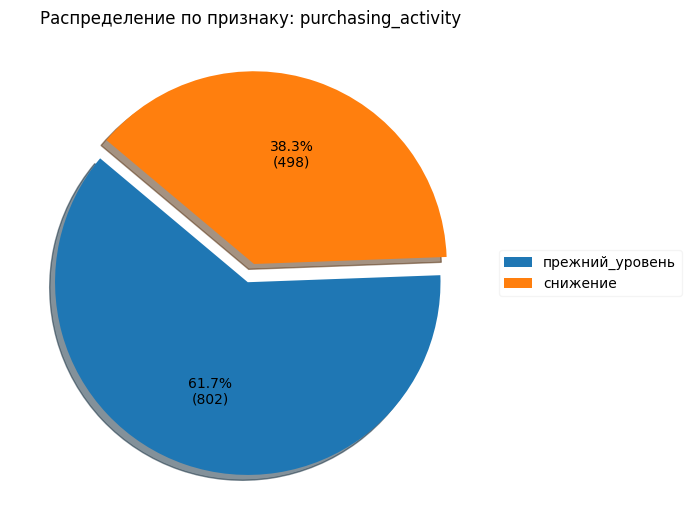

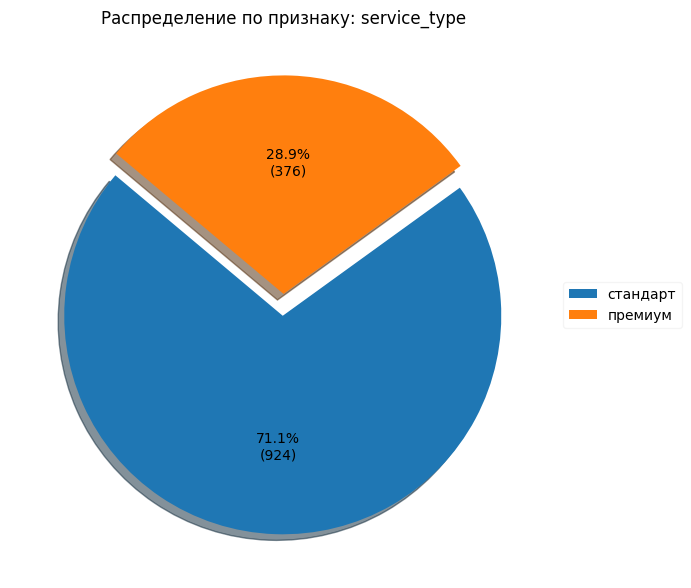

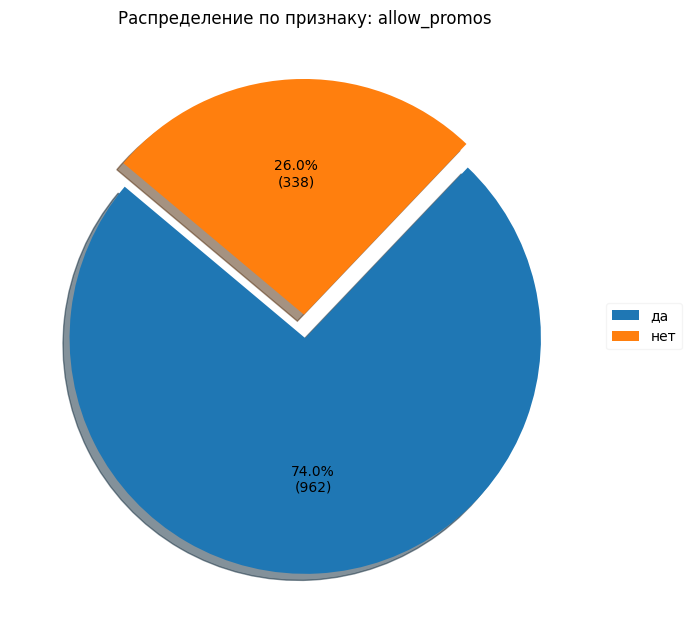

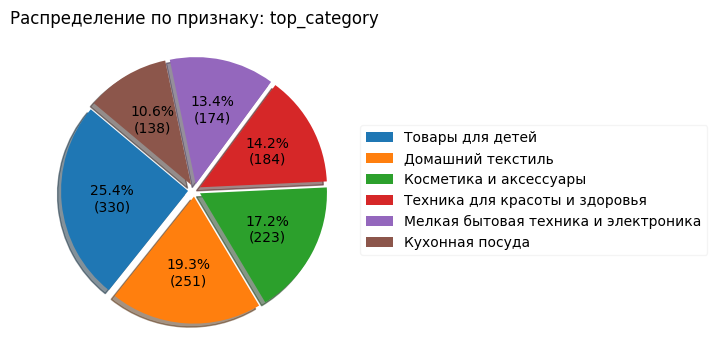

In [41]:
# строим круговые диаграммы для категориальных признаков
for col in cat_cols:
    counts = customers_data[col].value_counts(dropna=False)
    labels = counts.index
    sizes = counts.values
    explode = [0.05] * len(labels) # чуть сдвигаем каждый сектор

    def make_autopct(values): # функция для корректного подсчета абсолютных значений
        def my_autopct(pct):
            total = sum(values)
            absolute = int(round(pct * total / 100.0))
            return f"{pct:.1f}%\n({absolute})"
        return my_autopct

    plt.figure(figsize=(7, 7))
    plt.pie(
        sizes,
        labels=None,
        autopct=make_autopct(sizes),
        startangle=140,
        explode=explode,
        shadow=True
    )
    plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, framealpha=0.2)
    plt.title(f'Распределение по признаку: {col}')
    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по категориальным признакам customers_data:</strong>
  <ul>
    <li><strong>purchasing_activity:</strong> Это наша целевая переменная, и её распределение выглядит сбалансированным для задачи классификации. Нет сильного перекоса в сторону одного класса, что хорошо для обучения модели.</li>
    <li><strong>service_type:</strong> Большинство клиентов (около 71%) имеют стандартный тип сервиса. Этот признак может быть важен, так как "премиум" клиенты могут иметь другую динамику активности.</li>
    <li><strong>allow_promos:</strong> Подавляющее большинство клиентов (около 74%) дали согласие на получение дополнительных предложений. Это важный признак, который показывает открытость клиента к маркетинговым коммуникациям.</li>  
    <li><strong>top_category:</strong> Здесь представлено 6 различных категорий, которые распределены относительно равномерно, без доминирования одной. Ценный признак, который характеризует продуктовые предпочтения клиента</li>  
  </ul>
</div>

### revenue_data

Начнем с исследования количественных признаков:

In [42]:
# статистическое описание количественного признака
revenue_data['revenue'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64

В статистическом описании признака **revenue** обнаружен явный выброс: максимальное значение 106862.2 при среднем значении около 5000 и 75-м процентиле около 5400. Это значение более чем в 20 раз превышает среднее, что указывает на возможную ошибку. Проверим:

In [43]:
# убедимся, что выброс один
revenue_data['revenue'].sort_values(ascending=False).head()

98      106862.2
435       7799.4
262       7605.3
1481      7557.0
2388      7547.8
Name: revenue, dtype: float64

In [44]:
# проверим id
revenue_data[revenue_data['revenue'] == 106862.2]

,id,period,revenue
98,215380,текущий_месяц,106862.2


In [45]:
# выведем информацию о покупателе
display(customers_data[customers_data['id'] == 215380])
display(revenue_data[revenue_data['id'] == 215380])
display(web_time_data[web_time_data['id'] == 215380])
display(profit_data[profit_data['id'] == 215380])

,id,purchasing_activity,service_type,allow_promos,marketing_avg,marketing_current,days_since_signup,promo_share,top_category,avg_category_views,unpaid_items_q,service_errors,pages_per_visit
32,215380,снижение,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7


,id,period,revenue
96,215380,позапрошлый_месяц,5051.0
97,215380,прошлый_месяц,6077.0
98,215380,текущий_месяц,106862.2


,id,period,minutes_online
64,215380,прошлый_месяц,12
65,215380,текущий_месяц,14


,id,profit
32,215380,3.88


Скорее всего клиент попал на большую акцию и закупился один раз на крупную сумму, но прибыль от клиента все равно близка к медианной. Есть смысл удалить данные об этом клиенте из всех датасетов, чтобы они не искажали общую картину и не повлияли на моделирование:

In [46]:
# удаляем данные об этом покупателе
revenue_data = revenue_data[revenue_data['id'] != 215380].copy()
customers_data = customers_data[customers_data['id'] != 215380].copy()
web_time_data = web_time_data[web_time_data['id'] != 215380].copy()
profit_data = profit_data[profit_data['id'] != 215380].copy()

# проверяем наличие максимальных и минимальных выбросов
print(revenue_data['revenue'].sort_values(ascending=False).head())
print(revenue_data['revenue'].sort_values(ascending=False).tail())

435     7799.4
262     7605.3
1481    7557.0
2388    7547.8
566     7467.9
Name: revenue, dtype: float64
34    0.0
29    0.0
28    0.0
2     0.0
0     0.0
Name: revenue, dtype: float64


Также в данных есть некоторое количество нулевых значений. Учитывая то, что нам необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев (таких, которые что-либо покупали в этот период), следует удалить покупателей с нулевой выручкой:

In [47]:
# группируем по id и считаем количество месяцев с выручкой больше 0
fully_active_ids = revenue_data.groupby('id')['revenue'].apply(lambda x: (x > 0).all())

# оставляем только тех, у кого выручка > 0 в каждом из 3 месяцев
valid_ids = fully_active_ids[fully_active_ids].index

# оставляем в данных только активных покупателей
customers_data = customers_data[customers_data['id'].isin(valid_ids)]
revenue_data = revenue_data[revenue_data['id'].isin(valid_ids)]
web_time_data = web_time_data[web_time_data['id'].isin(valid_ids)]
profit_data = profit_data[profit_data['id'].isin(valid_ids)]

Теперь в данных останутся только покупатели с историей покупок за 3 месяца, которые действительно интересны для анализа снижения активности. Проанализируем распределение и выбросы после удаления выбивающихся значений:

/var/folders/xy/6r_kl3bn3_v10pnffwwnrv740000gn/T/ipykernel_40601/887617895.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_revenue[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])
/var/folders/xy/6r_kl3bn3_v10pnffwwnrv740000gn/T/ipykernel_40601/887617895.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_revenue[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])
/var/folders/xy/6r_kl3bn3_v10pnffwwnrv740000gn/T/ipykernel_40601/887617895.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_revenue[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])


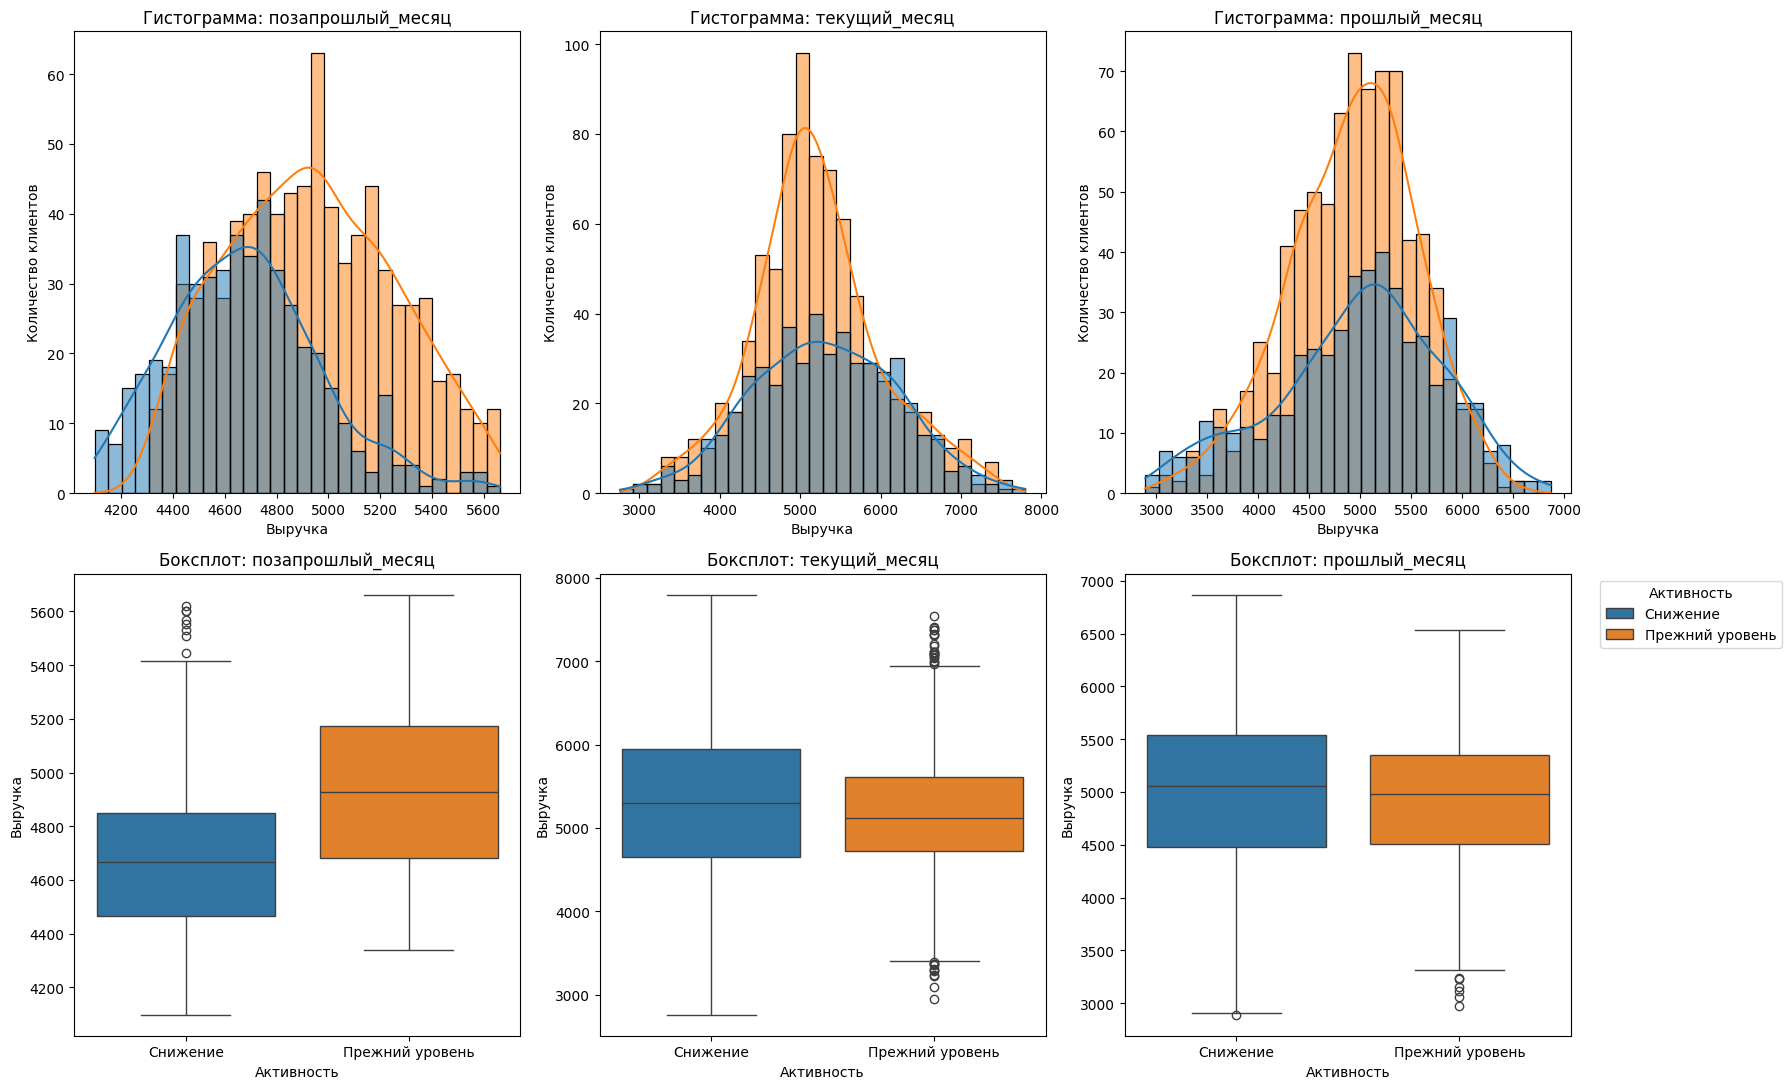

In [48]:
# объединяем данные о выручке с данными о клиентах
revenue_merged = pd.merge(
    revenue_data,
    customers_data[['id', 'purchasing_activity']],
    on='id',
    how='left')

# графики для выручки
periods_revenue = revenue_merged['period'].unique()
n_periods_revenue = len(periods_revenue)

fig_revenue, axes_revenue = plt.subplots(2, n_periods_revenue, figsize=(6 * n_periods_revenue, 11))

for i, period in enumerate(periods_revenue):
    # фильтруем данные по текущему периоду
    data_filtered = revenue_merged[revenue_merged['period'] == period]

    # гистограмма
    sns.histplot(
        data=data_filtered, 
        x='revenue', 
        hue='purchasing_activity', 
        kde=True, 
        ax=axes_revenue[0, i], 
        bins=30, 
        legend=False)
    axes_revenue[0, i].set_title(f'Гистограмма: {period}')
    axes_revenue[0, i].set_xlabel('Выручка')
    axes_revenue[0, i].set_ylabel('Количество клиентов')

    # боксплот
    sns.boxplot(
        data=data_filtered, 
        x='purchasing_activity', 
        y='revenue', 
        hue='purchasing_activity', 
        ax=axes_revenue[1, i], 
        legend=False)
    
    axes_revenue[1, i].set_title(f'Боксплот: {period}')
    axes_revenue[1, i].set_xlabel('Активность')
    axes_revenue[1, i].set_ylabel('Выручка')
    axes_revenue[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])

# добавим общую легенду в конце, чтобы она была единой для всех графиков
plt.legend(title='Активность', labels=['Снижение', 'Прежний уровень'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Теперь исследуем категориальные признаки:

In [49]:
# распределение категориальных признаков
print(f"Уникальные значения {'period'}:")
print(revenue_data['period'].value_counts(dropna=False))

Уникальные значения period:
period
позапрошлый_месяц    1296
текущий_месяц        1296
прошлый_месяц        1296
Name: count, dtype: int64


<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по признакам revenue_data:</strong>
  <ul>
    <li><strong>Позапрошлый месяц:</strong> Медианная выручка клиентов, которые сохранили активность, была выше, чем у тех, кто её снизил. Это означает, что многие ценные клиенты изначально находились в стабильной, лояльной группе, а не в группе риска.</li>
    <li><strong>Прошлый месяц:</strong> Медианная выручка обеих групп выравнивается. На боксплоте видно, что медиана синей группы немного выше, но разница не так заметна. Уже замечаем тревожное изменение - наблюдается снижение активности среди высокодоходных клиентов.</li>
    <li><strong>Текущий месяц:</strong> Тенденция подтверждается. Медианная выручка группы риска превышает медианную выручку лояльных клиентов. Это важный сигнал для бизнеса: самая прибыльная часть клиентской базы демонстрирует признаки снижения активности.</li> 
    <li>Выручка сама по себе не является сильным предсказательным признаком для определения снижения покупательской активности.</li>
    <li>Распределение данных по категориям является полностью сбалансированным. Это означает, что для каждого из трёх периодов у нас есть одинаковое количество наблюдений.</li>
  </ul>
</div>

### web_time_data

Начнем с исследования количественных признаков:

In [50]:
# статистическое описание количественного признака
web_time_data['minutes_online'].describe()

count    2592.000000
mean       13.340664
std         4.083469
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes_online, dtype: float64

/var/folders/xy/6r_kl3bn3_v10pnffwwnrv740000gn/T/ipykernel_40601/434309005.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_web_time[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])
/var/folders/xy/6r_kl3bn3_v10pnffwwnrv740000gn/T/ipykernel_40601/434309005.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_web_time[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])


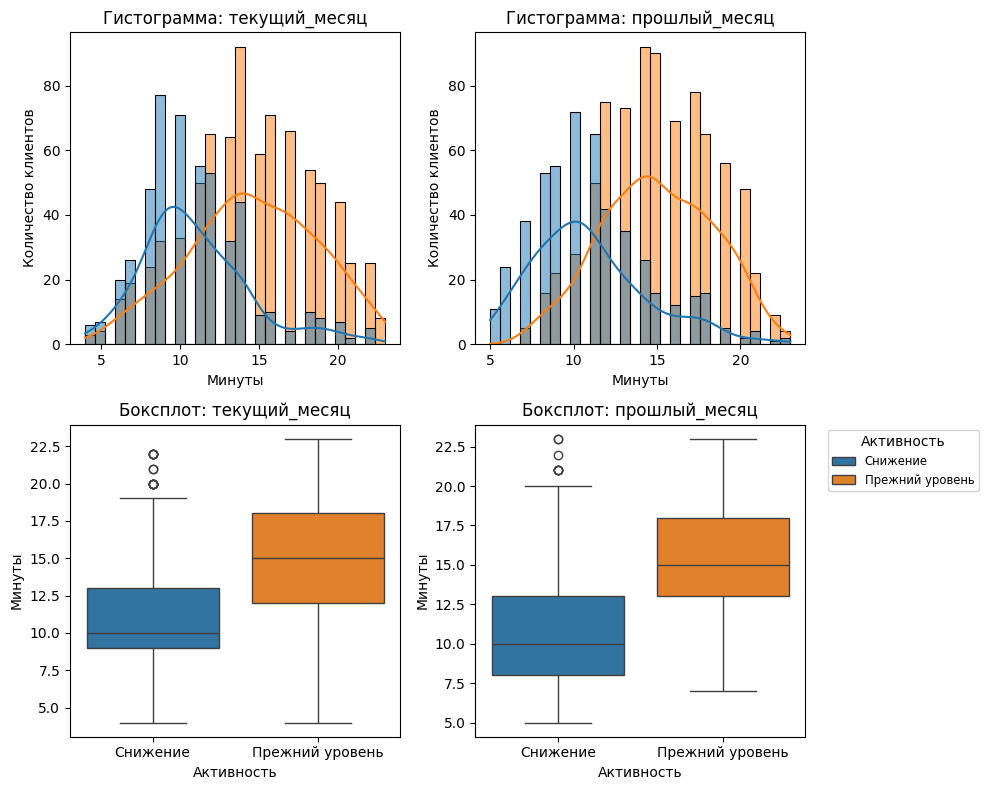

In [51]:
# объединяем данные о времени с данными о клиентах
web_time_merged = pd.merge(
    web_time_data,
    customers_data[['id', 'purchasing_activity']],
    on='id',
    how='left')

# графики для времени
periods_web_time = web_time_merged['period'].unique()
n_periods_web_time = len(periods_web_time)

fig_web_time, axes_web_time = plt.subplots(2, n_periods_web_time, figsize=(5 * n_periods_web_time, 8))


for i, period in enumerate(periods_web_time):
    # фильтруем данные по текущему периоду
    data_filtered = web_time_merged[web_time_merged['period'] == period]

    # гистограмма
    sns.histplot(
        data=data_filtered, 
        x='minutes_online', 
        hue='purchasing_activity', 
        kde=True, 
        ax=axes_web_time[0, i], 
        bins=30, 
        legend=False)
    
    axes_web_time[0, i].set_title(f'Гистограмма: {period}')
    axes_web_time[0, i].set_xlabel('Минуты')
    axes_web_time[0, i].set_ylabel('Количество клиентов')

    # боксплот
    sns.boxplot(
        data=data_filtered, 
        x='purchasing_activity', 
        y='minutes_online', 
        hue='purchasing_activity', 
        ax=axes_web_time[1, i], 
        legend=False)
    
    axes_web_time[1, i].set_title(f'Боксплот: {period}')
    axes_web_time[1, i].set_xlabel('Активность')
    axes_web_time[1, i].set_ylabel('Минуты')
    axes_web_time[1, i].set_xticklabels(['Снижение', 'Прежний уровень'])  
    
# общая легенда    
plt.legend(title='Активность', labels=['Снижение', 'Прежний уровень'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

Теперь исследуем категориальные признаки:

In [52]:
# распределение категориальных признаков
print(f"Уникальные значения {'period'}:")
print(web_time_data['period'].value_counts(dropna=False))

Уникальные значения period:
period
текущий_месяц    1296
прошлый_месяц    1296
Name: count, dtype: int64


<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по признакам web_time_data:</strong>
  <ul>
    <li>В обоих периодах распределения minutes_online для обеих групп ('снижение' и 'прежний_уровень') имеют нормальный вид, но с заметным сдвигом: клиенты, у которых активность снизилась, проводят на сайте заметно меньше времени, чем клиенты с прежним уровнем активности.</li>
    <li>Медианное время для группы 'прежний_уровень' (около 14 минут) значительно выше, чем для группы 'снижение' (около 10 минут).</li>  
    <li>Низкое время, проведенное на сайте является характерным поведением для клиентов, у которых покупательская активность снизилась. У клиентов с прежней активностью разброс времени на сайте более широкий.</li> 
    <li>Количество времени, проведенного на сайте (minutes_online), является сильным предсказательным признаком.</li>
    <li>В группе 'снижение' наблюдаются выбросы с высоким значением времени, проведенного на сайте. Это может указывать на то, что даже среди клиентов с пониженной активностью есть те, кто по каким-то причинам проводит на сайте много времени, но не совершает покупок.</li>
    <li>Распределение данных по категориям является полностью сбалансированным. Это означает, что для каждого из двух периодов у нас есть одинаковое количество наблюдений.</li>  
  </ul>
</div>

### profit_data

Исследуем количественный признак:

In [53]:
# статистическое описание количественного признака
profit_data['profit'].describe()

count    1296.000000
mean        3.997701
std         1.011198
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

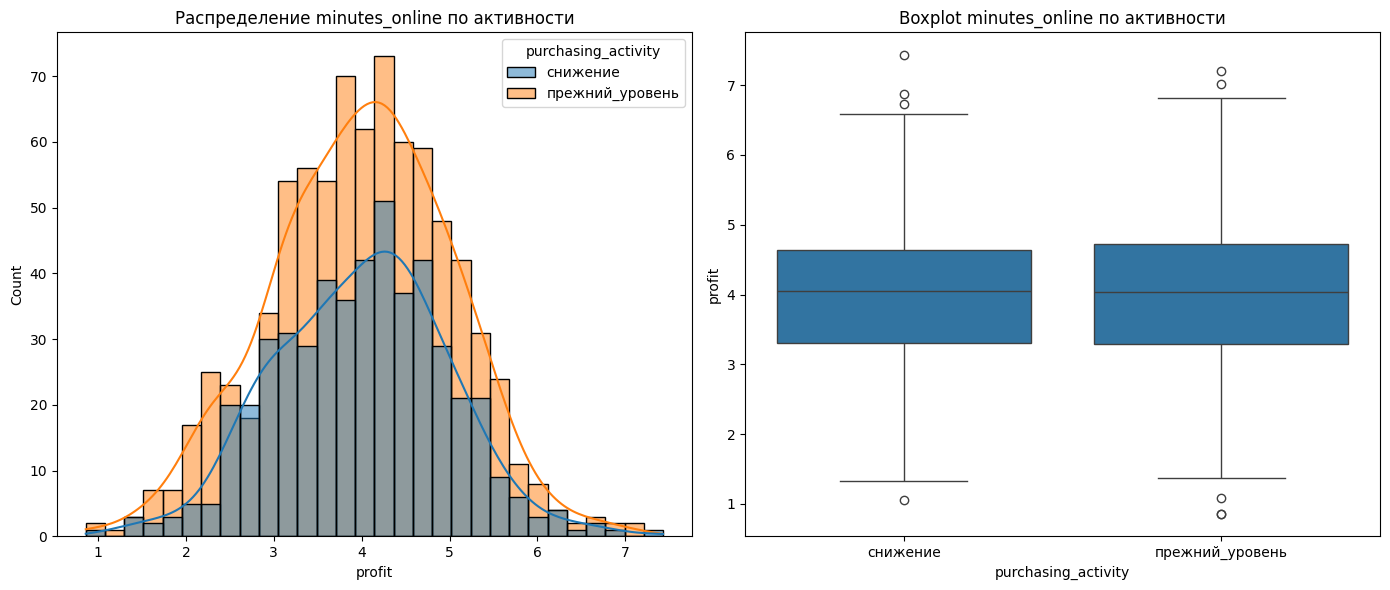

In [54]:
# объединяем данные по 'id' для учета целевого признака
merged_profit = profit_data.merge(customers_data[['id', 'purchasing_activity']], on='id')

# строим распределения и boxplot для признака
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=merged_profit, x='profit', hue='purchasing_activity', kde=True, bins=30)
plt.title('Распределение minutes_online по активности')

plt.subplot(1, 2, 2)
sns.boxplot(data=merged_profit, x='purchasing_activity', y='profit')
plt.title('Boxplot minutes_online по активности')

plt.tight_layout()
plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по profit_data:</strong>
  <ul>
    <li>Распределения прибыли для обеих групп ('снижение' и 'прежний_уровень') имеют схожую, почти нормальную форму и сильно перекрываются.</li>
    <li>Несмотря на перекрытие, клиенты с прежним уровнем активности в среднем приносят больше прибыли, чем клиенты со снижением активности.</li>  
    <li>В обеих группах есть выбросы как в нижней, так и в верхней части распределения, что указывает на наличие как очень прибыльных, так и низкоприбыльных клиентов, независимо от их активности.</li>  
  </ul>
</div>

## Объединение таблиц

Объединим таблицы, которые понадобятся нам для моделирования, а именно **customers_data**, **revenue_data** и **web_time_data**:

In [55]:
# поворачиваем таблицу с выручкой
revenue_pivot = revenue_data.pivot(index='id', columns='period', values='revenue')
revenue_pivot.columns = [f'revenue_{col}' for col in revenue_pivot.columns]
revenue_pivot.reset_index(inplace=True)

# поворачиваем таблицу со временем
web_time_pivot = web_time_data.pivot(index='id', columns='period', values='minutes_online')
web_time_pivot.columns = [f'minutes_online_{col}' for col in web_time_pivot.columns]
web_time_pivot.reset_index(inplace=True)

# объединяем по id
full_data = customers_data.merge(revenue_pivot, on='id', how='inner')
full_data = full_data.merge(web_time_pivot, on='id', how='inner')

# проверим колонки
full_data.head(1)

,id,purchasing_activity,service_type,allow_promos,marketing_avg,marketing_current,days_since_signup,promo_share,top_category,avg_category_views,unpaid_items_q,service_errors,pages_per_visit,revenue_позапрошлый_месяц,revenue_прошлый_месяц,revenue_текущий_месяц,minutes_online_прошлый_месяц,minutes_online_текущий_месяц
0,215349,снижение,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10


В итоговой таблице мы сделали отдельные столбцы для каждого периода в данных о выручке и времени на сайте. Для удобства переименуем новые столбцы:

In [56]:
# для удобства переименуем столбцы
full_data.rename(columns={
    'revenue_позапрошлый_месяц': 'revenue_prelast_month',
    'revenue_прошлый_месяц': 'revenue_last_month',
    'revenue_текущий_месяц': 'revenue_current_month',
    'minutes_online_прошлый_месяц': 'minutes_last_month',
    'minutes_online_текущий_месяц': 'minutes_current_month'
}, inplace=True)

# создаем копию датафрейма
full_data_copy = full_data.copy()

# ознакомление с новым датасетом
full_data.head(1)

,id,purchasing_activity,service_type,allow_promos,marketing_avg,marketing_current,days_since_signup,promo_share,top_category,avg_category_views,unpaid_items_q,service_errors,pages_per_visit,revenue_prelast_month,revenue_last_month,revenue_current_month,minutes_last_month,minutes_current_month
0,215349,снижение,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10


## Корреляционный анализ

На данном этапе мы изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между ними, построим диаграммы рассеяния и проанализируем корреляции.

Для этого будем рассматривать объединенные данные о покупателях - **full_data**.

На этапе исследовательского анализа мы заметили, что не все признаки распределены нормально, поэтому необходимо использовать подходы, которые устойчивы к выбросам и ненормальному распределению. Для этого построим матрицу корреляции по коэффициенту Phi (Phik), которая используется для категориальных признаков или пар числовых-категориальных признаков. Она помогает выявить в том числе нелинейные зависимости. Это важно, чтобы понять влияние категориальных признаков на целевой и избежать потери значимой информации при моделировании:

In [57]:
# отбираем количественные признаки, чтобы передать их как параметр при построении матрицы
# для корректного разделения признаков
num_cols = ['id', 'marketing_avg', 'marketing_current', 
            'days_since_signup', 'promo_share', 'avg_category_views', 
            'unpaid_items_q', 'service_errors', 'pages_per_visit',
            'revenue_prelast_month', 'revenue_last_month', 'revenue_current_month',
            'minutes_last_month', 'minutes_current_month']

# вычисляем phik корреляции
phik_corr = full_data.phik_matrix(interval_cols=num_cols)

phik_corr

,id,purchasing_activity,service_type,allow_promos,marketing_avg,marketing_current,days_since_signup,promo_share,top_category,avg_category_views,unpaid_items_q,service_errors,pages_per_visit,revenue_prelast_month,revenue_last_month,revenue_current_month,minutes_last_month,minutes_current_month
id,1.000000,0.984597,0.116473,0.019783,0.466290,0.000000,0.050714,0.413956,0.171846,0.353945,0.418111,0.204583,0.608831,0.421755,0.238373,0.173750,0.564878,0.473579
purchasing_activity,0.984597,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.497393,0.224638,0.197213,0.685138,0.576770
service_type,0.116473,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.069704,0.000000,0.124216,0.131814,0.000000
allow_promos,0.019783,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.000000,0.080842,0.060907,0.038387,0.000000
marketing_avg,0.466290,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.315331,0.155476,0.039795,0.363950,0.330601
marketing_current,0.000000,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.000000,0.051824,0.000000,0.107945,0.061410
days_since_signup,0.050714,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.113200,0.125572,0.147048,0.026448,0.101481
promo_share,0.413956,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.226381,0.060733,0.071094,0.262324,0.250558
top_category,0.171846,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.043528,0.252097,0.237240,0.195233,0.089883
avg_category_views,0.353945,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.176828,0.098440,0.092597,0.159837,0.182568


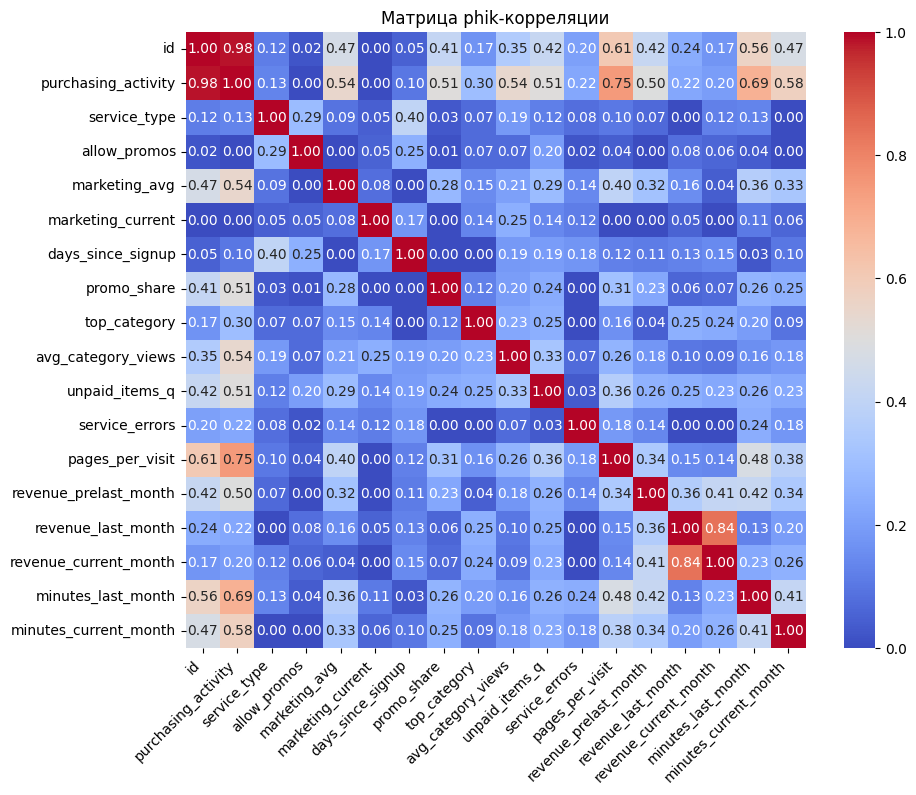

In [58]:
# визуализируем
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица phik-корреляции")
plt.xticks(rotation=45, ha='right')
plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции с целевым признаком (purchasing_activity):</strong>
  <ul>
    <li><strong>pages_per_visit (0.75)</strong>: Очень сильная положительная корреляция. Клиенты, которые просматривают больше страниц за визит, с большей вероятностью сохраняют свою активность.</li>
    <li><strong>minutes_last_month (0.69), minutes_current_month (0.58)</strong>: Сильная положительная корреляция. Время, проведенное на сайте, напрямую связано с уровнем покупательской активности.</li>  
    <li><strong>marketing_avg (0.54), avg_category_views (0.54)</strong>: Умеренная положительная корреляция. Эти признаки также хорошо связаны с целевым признаком.</li>  
  </ul>
</div>

Теперь построим матрицу диаграмм рассеяния, чтобы определить характер взаимосвязей (линейный/нелинейный):

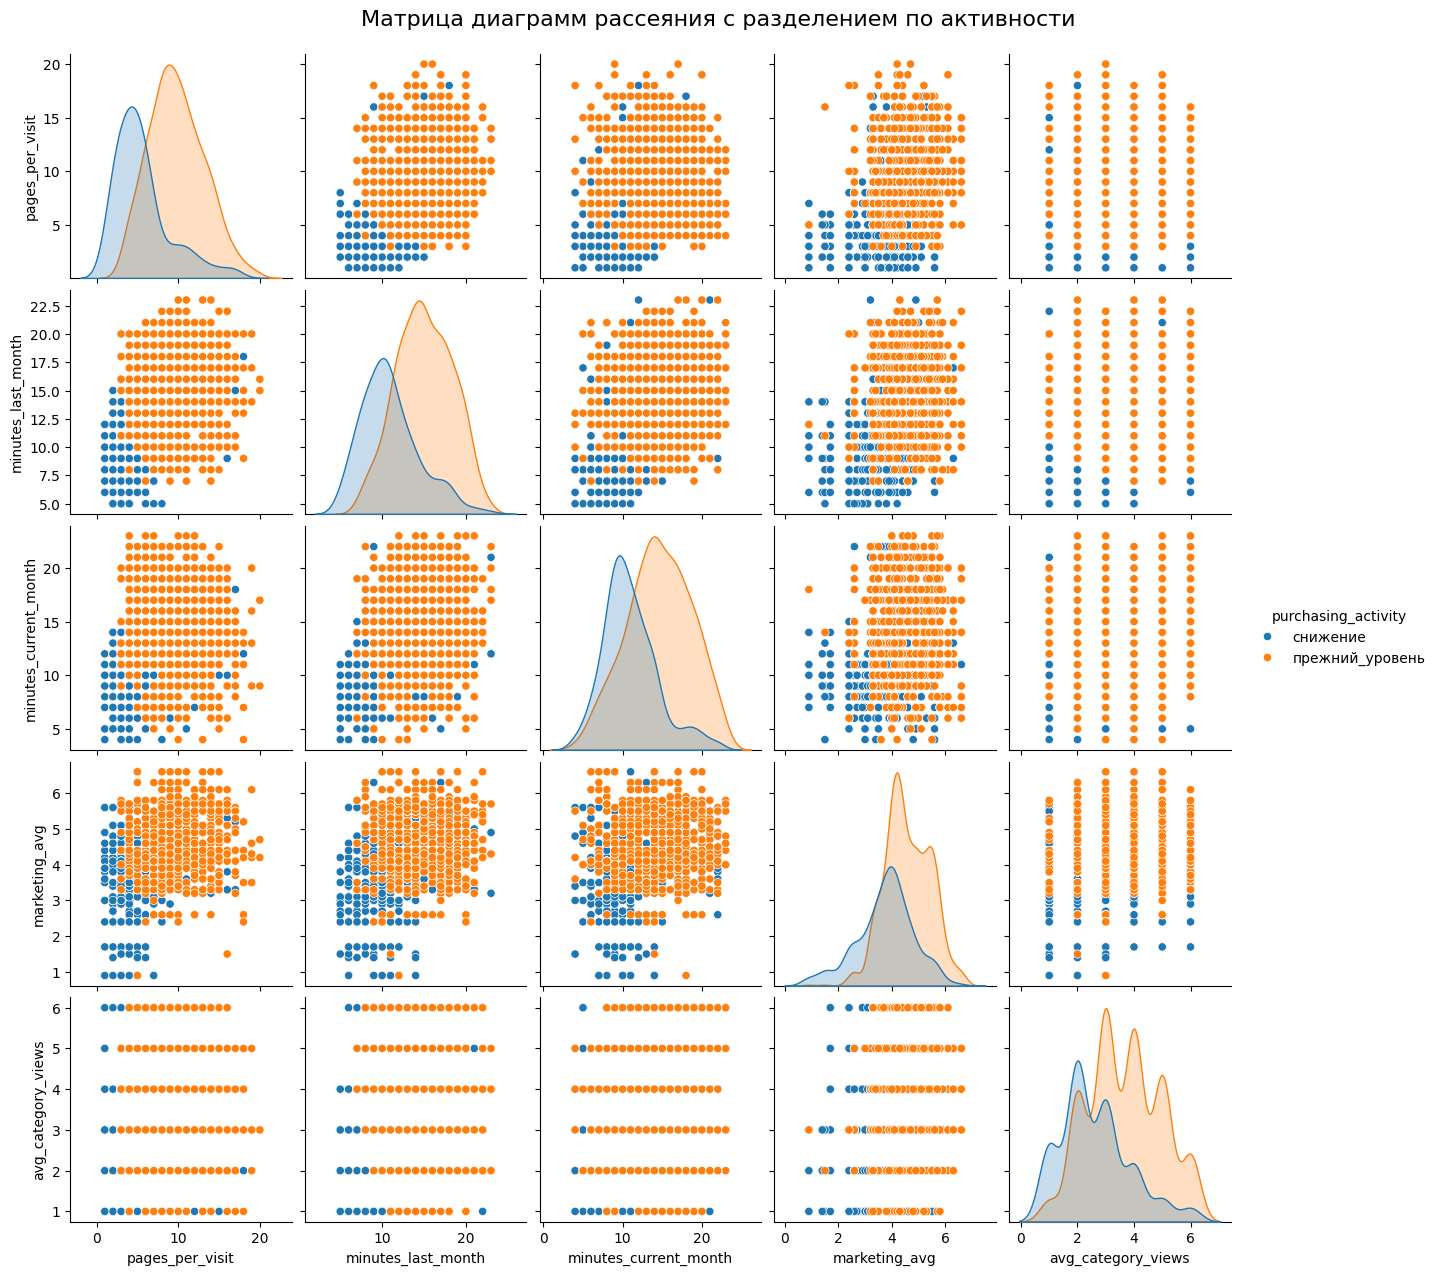

In [59]:
# cтроим матрицу диаграмм рассеяния с разделением по целевому признаку
sns.pairplot(data=full_data, 
             vars=['pages_per_visit', 'minutes_last_month', 'minutes_current_month', 'marketing_avg', 'avg_category_views'], 
             hue='purchasing_activity', height=2.5)

# отображаем графики
plt.suptitle('Матрица диаграмм рассеяния с разделением по активности', y=1.02, fontsize=16)
plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Вывод на основе анализа графиков:</strong>
  <ul>
Матрица диаграмм рассеяния подтверждает выводы, сделанные на основе корреляционной матрицы и гистограмм. Признаки, отражающие глубину и время взаимодействия с сайтом (pages_per_visit, minutes_last_month, minutes_current_month, avg_category_views), являются наиболее важными предикторами покупательской активности.
  </ul>
</div>

Также исследуем природу крайне высокой корреляции между целевым признаком и id клиента, хоть мы и не будем использовать признак в моделях: 

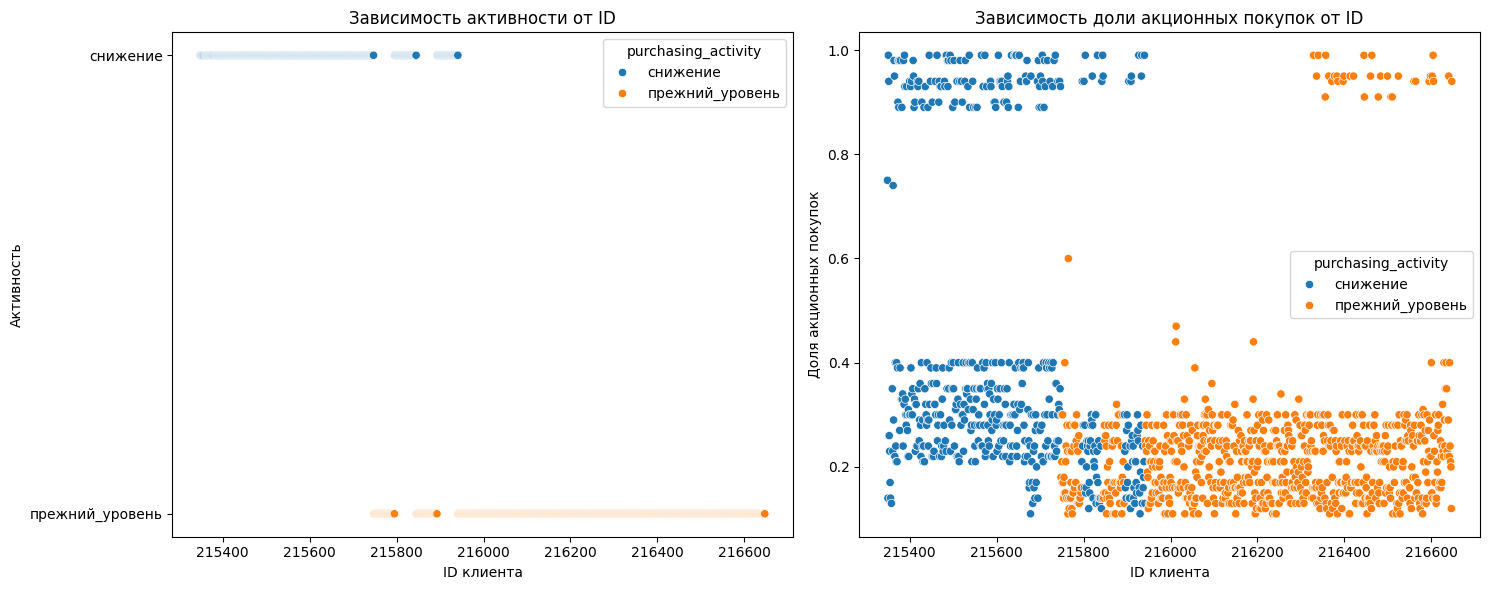

In [60]:
plt.figure(figsize=(15, 6))

# scatterplot: id vs целевой признак
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=full_data,
    x='id',
    y='purchasing_activity',
    hue='purchasing_activity')

plt.title('Зависимость активности от ID')
plt.xlabel('ID клиента')
plt.ylabel('Активность')


# scatterplot: id vs доля акционных покупок
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=full_data,
    x='id',
    y='promo_share',
    hue='purchasing_activity')

plt.title('Зависимость доли акционных покупок от ID')
plt.xlabel('ID клиента')
plt.ylabel('Доля акционных покупок')

plt.tight_layout()
plt.show()

Основываясь на представленных графиках, можно сделать вывод, что признак id не является случайным идентификатором, а несет в себе информацию, напрямую связанную с поведением клиентов:

- **График «Зависимость активности от ID»**: Можно увидеть, что значения id четко разделены по двум категориям. Клиенты с id примерно до 215800 снизили свою активность, в то время как клиенты с id от 215800 до 216000 сохранили её. Это явный признак утечки данных.

- **График «Зависимость доли акционных покупок от ID»**: Аналогично, мы видим, что клиенты из группы «снижение» сосредоточены в левой части графика, а клиенты из группы «прежний уровень» — в правой. Этот паттерн говорит о том, что ваш набор данных не является случайной выборкой.

Теперь дополнительно исследуем разницу в выручке за текущий и прошлый период (между признаками наблюдается высокая корреляция):

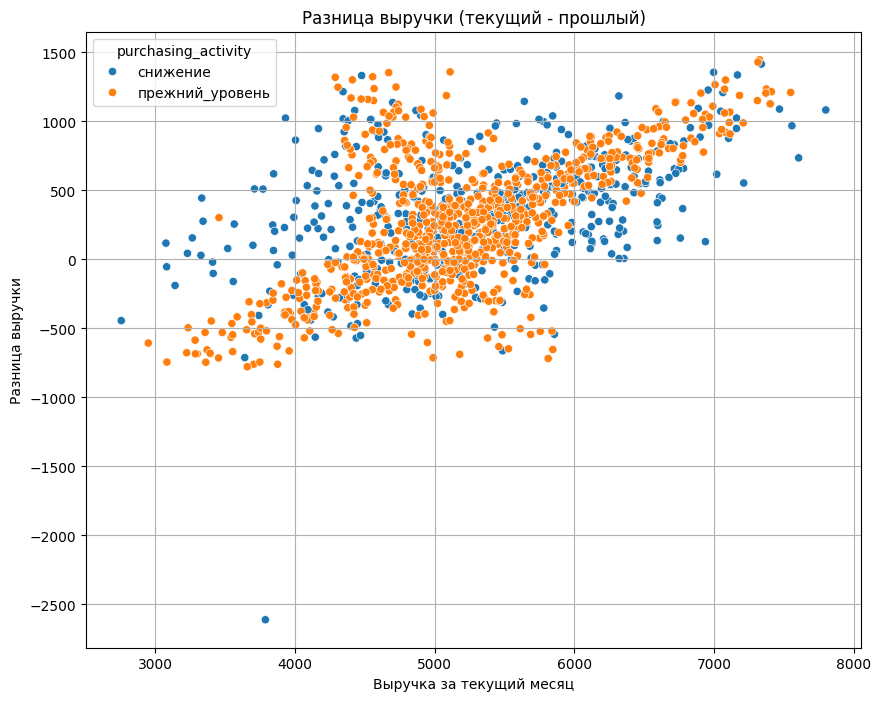

In [61]:
# создание второй переменной-разницы
full_data['revenue_diff_last_to_current'] = full_data['revenue_current_month'] - full_data['revenue_last_month']

# scatterplot: Разница между выручкой за текущий и прошлый период
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=full_data,
    x='revenue_current_month',
    y='revenue_diff_last_to_current',
    hue='purchasing_activity')
    
plt.title('Разница выручки (текущий - прошлый)')
plt.xlabel('Выручка за текущий месяц')
plt.ylabel('Разница выручки')
plt.grid(True)
plt.show()

На данном графике мы видим:

- **Неоднородность лояльной группы**: «Крестик» формируется оранжевыми точками («Прежний уровень»), что говорит о том, что эта группа состоит из двух подгрупп: стабильных клиентов (с нулевой разницей в выручке) и нестабильных клиентов (с большими колебаниями).

- **Разнообразие в группе риска**: Синяя группа («Снижение») не имеет такого четкого паттерна. Их траты просто снижаются, но по-разному.

Это означает, что для удержания клиентов нужно разрабатывать дифференцированные стратегии, учитывающие особенности каждой подгруппы.

Что касается корреляции остальных признаков между собой, то корреляция ниже 0.95 редко приводит к эффектам мультиколлинеарности. К тому же в моделях есть регуляризации, которые борятся с мультиколлинеарностью и при более экстремальных показателях корреляции. Другое дело, что нам в любом случае будет невыгодно брать в модель два признака, которые дублируют друг друга. Такиe признаки у нас есть:

- **revenue_last_month** и **revenue_current_month** (0.84): Высокая корреляция. Это логично, поскольку выручка в соседние месяцы, как правило, сильно взаимосвязана.
- Есть смысл удалить признаки выручки за все 3 месяца и создать вместо них:
  - **revenue_trend**: разница между текущей и позапрошлой выручкой.
  - **avg_revenue**: среднее значение выручки за три месяца.

Устраним мультиколлинеарность признаков, а также удалим неинформативный признак id:

In [62]:
# удаляем признак id, так как он не несет предсказательной ценности
full_data = full_data.drop('id', axis=1)

# удаляем временные признаки для построения графиков
full_data = full_data.drop('revenue_diff_last_to_current', axis=1)

# создаем новые признаки на основе данных о выручке за три месяца
full_data['avg_revenue'] = full_data[['revenue_prelast_month', 'revenue_last_month', 'revenue_current_month']].mean(axis=1)
full_data['revenue_trend'] = full_data['revenue_current_month'] - full_data['revenue_prelast_month']

# удаляем старые признаки, чтобы избежать мультиколлинеарности
full_data = full_data.drop(['revenue_prelast_month', 'revenue_last_month', 'revenue_current_month'], axis=1)

# выводим информацию о датафрейме, чтобы убедиться, что признаки удалены и добавлены
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   purchasing_activity    1296 non-null   object 
 1   service_type           1296 non-null   object 
 2   allow_promos           1296 non-null   object 
 3   marketing_avg          1296 non-null   float64
 4   marketing_current      1296 non-null   int64  
 5   days_since_signup      1296 non-null   int64  
 6   promo_share            1296 non-null   float64
 7   top_category           1296 non-null   object 
 8   avg_category_views     1296 non-null   int64  
 9   unpaid_items_q         1296 non-null   int64  
 10  service_errors         1296 non-null   int64  
 11  pages_per_visit        1296 non-null   int64  
 12  minutes_last_month     1296 non-null   int64  
 13  minutes_current_month  1296 non-null   int64  
 14  avg_revenue            1296 non-null   float64
 15  reve

## Использование пайплайнов

### Подготовка данных

Для эффективной и воспроизводимой подготовки данных мы будем использовать ColumnTransformer. Он позволит нам одновременно применять разные преобразования к разным типам признаков: скейлеры для количественных (StandardScaler, MinMaxScaler), кодировщики для категориальных (OneHotEncoder, OrdinalEncoder). 

In [63]:
# кодирование целевого признака для использования в моделях ('снижение' - 0, 'прежний_уровень' - 1)
full_data['purchasing_activity_encoded'] = full_data['purchasing_activity'].apply(
    lambda x: 0 if x == 'снижение' else 1)

# разделение данных на X (признаки) и y (целевая переменная)
X = full_data.drop(['purchasing_activity', 'purchasing_activity_encoded'], axis=1)
y = full_data['purchasing_activity_encoded']

# ручное определение категориальных признаков
ohe_columns = ['allow_promos', 'top_category']
ord_columns = ['service_type']

# автоматическое определение числовых признаков, исключая категориальные
all_cat_columns = ohe_columns + ord_columns
num_columns = [col for col in X.columns if col not in all_cat_columns and pd.api.types.is_numeric_dtype(X[col])]

# разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)

Переходим к созданию пайплайнов для предобработки данных:

In [64]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[['стандарт', 'премиум']], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общиe пайплайны для подготовки данных
preprocessor_minmax = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

preprocessor_standard = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)    

### Обучение моделей

Мы будем обучать четыре модели, используя пайплайны: **KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC**. Пайплайн объединит этапы подготовки данных и обучения модели.

Cоздадим пайплайн для каждой модели и используем GridSearchCV для подбора гиперпараметров. Мы будем использовать метрику f1_weighted, так как она подходит для несбалансированных классов:

In [65]:
%%time

# KNeighborsClassifier
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor_minmax),
                           ('classifier', KNeighborsClassifier())])
knn_param_grid = {
    'preprocessor': [preprocessor_minmax, preprocessor_standard],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(knn_pipe, knn_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
knn_grid.fit(X_train, y_train)


# DecisionTreeClassifier
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor_standard),
                          ('classifier', DecisionTreeClassifier(random_state=42))])
dt_param_grid = {
    'preprocessor': [preprocessor_minmax, preprocessor_standard],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10]
}
dt_grid = GridSearchCV(dt_pipe, dt_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
dt_grid.fit(X_train, y_train)


# LogisticRegression
lr_pipe = Pipeline(steps=[('preprocessor', preprocessor_standard),
                          ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])
lr_param_grid = {
    'preprocessor': [preprocessor_minmax, preprocessor_standard],
    'classifier__C': [0.1, 1.0, 10.0]
}
lr_grid = GridSearchCV(lr_pipe, lr_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
lr_grid.fit(X_train, y_train)


# SVC
svc_pipe = Pipeline(steps=[('preprocessor', preprocessor_standard),
                          ('classifier', SVC(random_state=42))])
svc_param_grid = {
    'preprocessor': [preprocessor_minmax, preprocessor_standard],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__probability': [True]
}
svc_grid = GridSearchCV(svc_pipe, svc_param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
svc_grid.fit(X_train, y_train)

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/utils/extma

CPU times: user 324 ms, sys: 31.9 ms, total: 356 ms
Wall time: 1.18 s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__C': [0.1, 1.0, ...], 'classifier__kernel': ['linear', 'rbf'], 'classifier__probability': [True], 'preprocessor': [ColumnTransfo...nue_trend'])]), ColumnTransfo...nue_trend'])])]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ohe', ...), ('ord', ...), ...]"


### Выбор лучшей модели

Найдем лучшую комбинацию преобразований данных, модели и гиперпараметров:

In [66]:
# выводим результаты
results = {
    'KNeighborsClassifier': knn_grid.best_score_,
    'DecisionTreeClassifier': dt_grid.best_score_,
    'LogisticRegression': lr_grid.best_score_,
    'SVC': svc_grid.best_score_
}

best_model_name = max(results, key=results.get)

print(f"Результаты подбора гиперпараметров по f1-weighted:\n{results}")
print(f"\nЛучшая модель: {best_model_name} с f1-weighted = {results[best_model_name]:.4f}")

Результаты подбора гиперпараметров по f1-weighted:
{'KNeighborsClassifier': np.float64(0.8922894111889622), 'DecisionTreeClassifier': np.float64(0.8587618239335756), 'LogisticRegression': np.float64(0.8834601104163516), 'SVC': np.float64(0.8930370360989862)}

Лучшая модель: SVC с f1-weighted = 0.8930


<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по результатам на тренировочных данных:</strong>
  <ul>
    <li><strong>SVC</strong> показала самую высокую f1-weighted (0.8930), что говорит о наилучшем балансе между точностью (precision) и полнотой (recall) для нашей задачи. SVC отлично работает с задачами классификации.</li>
    <li><strong>KNeighborsClassifier</strong> также показал очень высокий результат (0.8922), практически наравне с SVC. Это говорит о том, что для наших данных хорошо работают методы, основанные на расстоянии.</li>  
    <li><strong>LogisticRegression и DecisionTreeClassifier</strong> показали результаты немного ниже (0.8834 и 0.8587 соответственно). Это не плохие результаты, но они уступают лидерам. Особенно заметно отстает дерево решений, что может указывать на то, что простые древовидные структуры не могут полностью уловить все тонкости взаимосвязей в данных.</li>  
  </ul>
</div>

Применим лучшую модель к тестовым данным:

Оценка лучшей модели на тестовых данных
F1-score: 0.8727
Accuracy: 0.8765
Precision: 0.8840
Recall: 0.8765


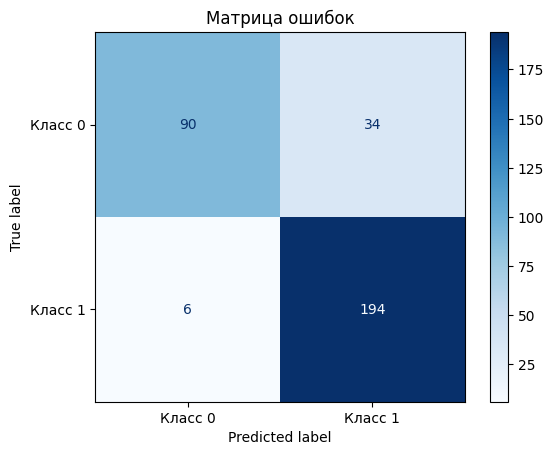

In [67]:
# получаем лучшую модель из GridSearchCV
best_model = svc_grid.best_estimator_

# делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# оцениваем модель на тестовых данных
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Оценка лучшей модели на тестовых данных")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# создаем объект ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Класс 0', 'Класс 1'])

# визуализируем
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы для бизнеса:</strong>
  <ul>
    <li><strong>Сравнение результатов:</strong> F1-score на тестовых данных (0.8727) немного ниже, чем на кросс-валидации (0.8930). Это нормально, так как кросс-валидация дает усредненную оценку на тренировочных данных, а тестовая выборка — это одно независимое испытание. Разница небольшая, что подтверждает устойчивость модели.</li> 
    <li><strong>Высокая полнота (Recall):</strong> Модель смогла обнаружить подавляющее большинство клиентов со сниженной активностью (194 из 200). Это означает, что она очень хорошо решает основную бизнес-задачу — выявление "проблемных" клиентов.</li>
    <li><strong>Ложные срабатывания:</strong> Хотя есть 34 ложных срабатывания, их количество не критично. Компания может оценить стоимость "лишних" коммуникаций и сравнить её со стоимостью упущенной выручки от ушедших клиентов. Вероятно, польза от удержания 194 клиентов перевешивает расходы на 34 ошибочные коммуникации.</li>  
    <li><strong>Готовность к внедрению:</strong> Модель показала высокую производительность и может быть рекомендована к внедрению для автоматического выявления клиентов, находящихся в зоне риска, и запуска программ по их удержанию.</li>   
  </ul>
</div>

## Анализ важности признаков

### Анализ важности признаков с помощью Permutation Importance

Этот метод простой и быстрый. Он оценивает, насколько падает производительность модели, если значения в столбце признака перемешать:

Permutation Importance:
                  feature  importance_mean  importance_std
10        pages_per_visit         0.060801        0.009814
11     minutes_last_month         0.034612        0.008416
12  minutes_current_month         0.028610        0.006456
2           marketing_avg         0.015270        0.007245
5             promo_share         0.014541        0.005744
14          revenue_trend         0.009685        0.005459
8          unpaid_items_q         0.008945        0.005509
6            top_category         0.005129        0.001993
4       days_since_signup         0.004349        0.003207
7      avg_category_views         0.003981        0.006376
0            service_type         0.003558        0.002978
1            allow_promos         0.002097        0.002339
3       marketing_current         0.000878        0.001442
9          service_errors         0.000828        0.003183
13            avg_revenue         0.000312        0.004540


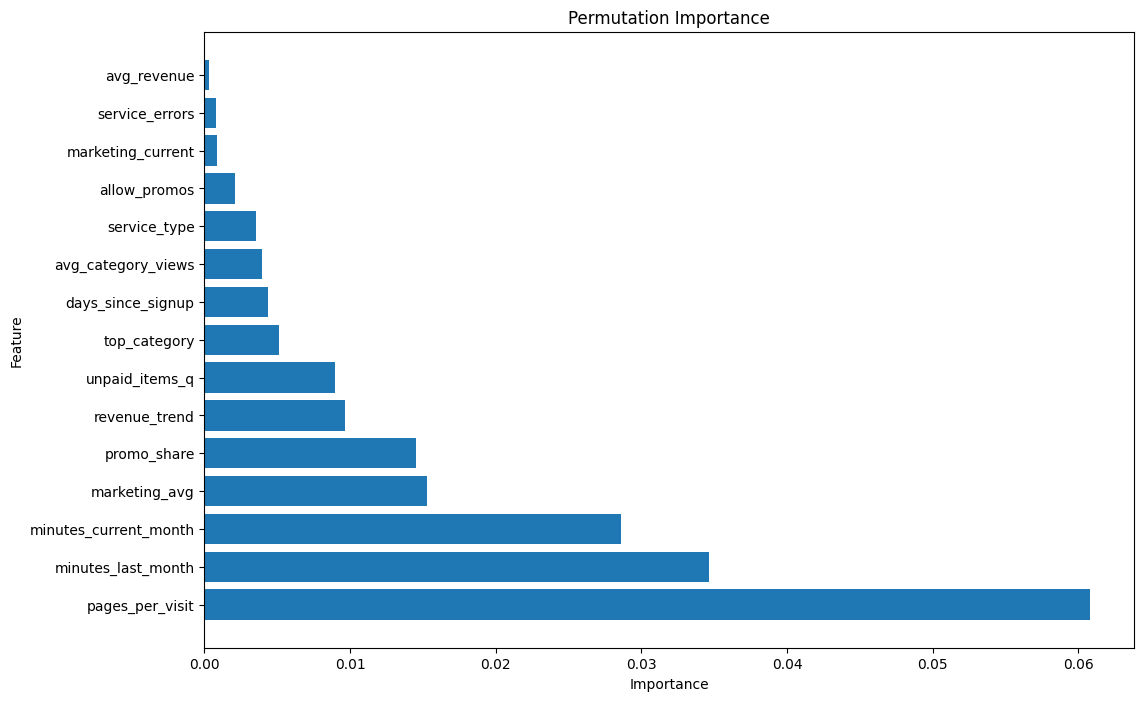

In [68]:
# вычисляем важность признаков
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1_weighted'
)

# создаем датафрейм для удобного отображения
perm_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print("Permutation Importance:")
print(perm_importance_df)

# строим график
plt.figure(figsize=(12, 8))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance_mean'])
plt.title('Permutation Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по Permutation Importance:</strong>
  <ul>
    <li><strong>Наиболее важные признаки:</strong> pages_per_visit, minutes_last_month и minutes_current_month - поведение на сайте сильнее всего влияет на снижение/сохранение активности.</li>
    <li><strong>Средне важные признаки:</strong> marketing_avg и promo_share — коммуникации и акции влияют, но меньше, чем поведение на сайте.</li>  
    <li><strong>Мало важные признаки:</strong> service_errors, avg_revenue, marketing_current, allow_promos, service_type, avg_category_views.</li>  
    <li><strong>Отбор признаков:</strong> В анализ SHAP можно не включать мало важные признаки, чтобы ускорить расчёт, они почти не дают новой информации (будем использовать KernelExplainer для SVC модели).</li>   
  </ul>
</div>

### Анализ важности признаков с помощью SHAP

Провести корректный SHAP-анализ для SVC (наша лучшая модель) сложнее по нескольким причинам. Во-первых, SVC не вычисляет вероятности напрямую, что делает необходимый для SHAP метод predict_proba вычислительно дорогим и медленным. Во-вторых, как нелинейная модель, SVC работает в сложных многомерных пространствах, что затрудняет интерпретацию влияния каждого признака. Наконец, используемый для анализа KernelExplainer требует фоновых данных, и, если не использовать небольшую выборку, вычисления могут занять огромное количество времени.

Поэтому есть смысл провести анализ на модели логистической регрессии (которая близка по качеству к лучшей модели), потому что она обеспечивает баланс между качеством и прозрачностью. SHAP-анализ для нее будет проще и намного быстрее, но все равно даст нам ценную информацию о признаках:

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


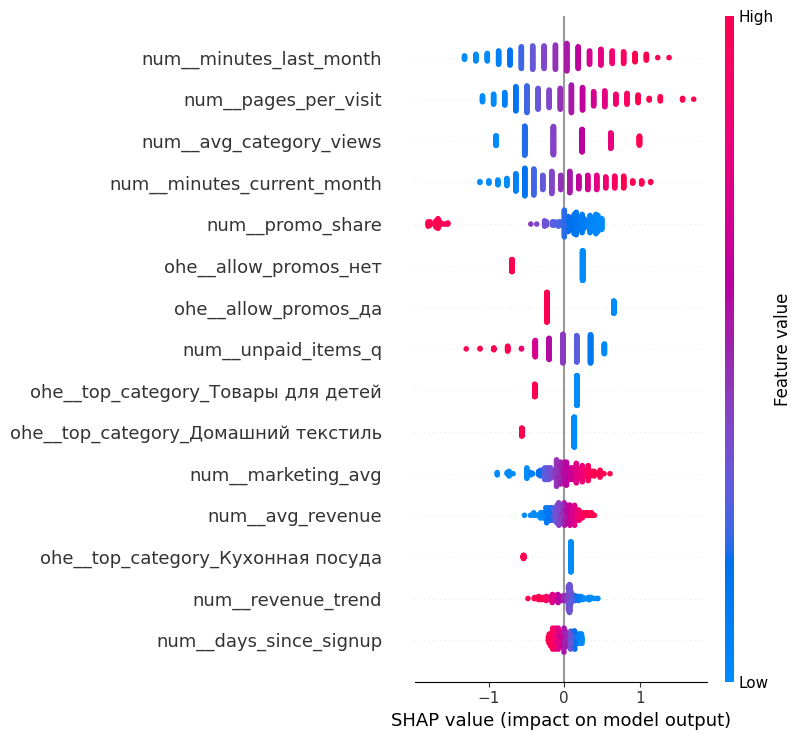

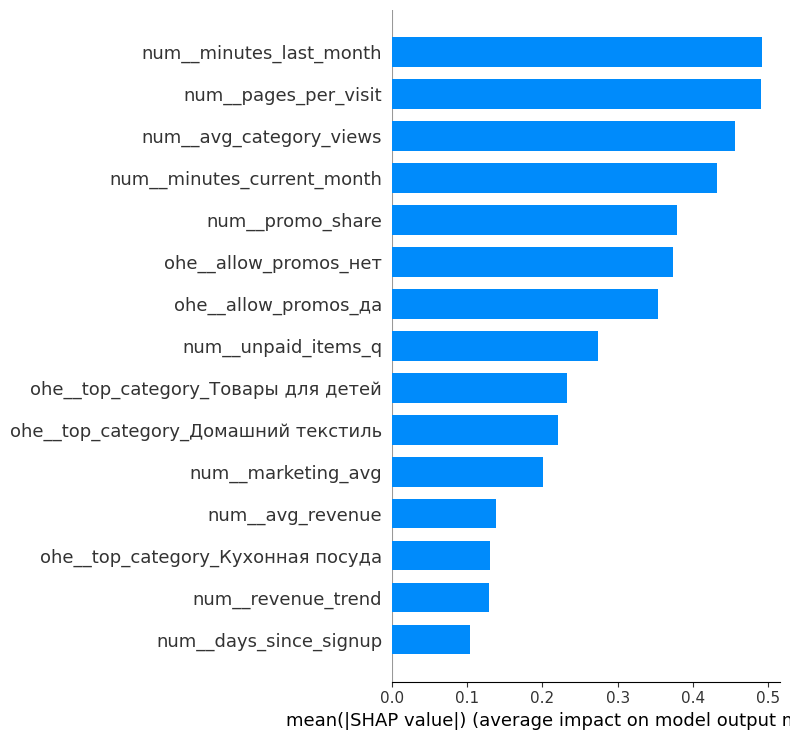

In [69]:
# берём лучшую модель из поиска для логистической регрессии
best_lr = lr_grid.best_estimator_

# трансформируем данные через лучший препроцессор
X_train_transformed = best_lr.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_lr.named_steps['preprocessor'].transform(X_test)

# получаем имена признаков после трансформации
feature_names = best_lr.named_steps['preprocessor'].get_feature_names_out()

# переводим в датафрейм для удобства
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# берём сам классификатор (LogisticRegression)
log_reg = best_lr.named_steps['classifier']

# создаём LinearExplainer
explainer = shap.LinearExplainer(log_reg, X_train_df, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_test_df)

# summary plot (распределение влияния признаков)
shap.summary_plot(shap_values, X_test_df, max_display=15)

# bar plot (средняя важность признаков)
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=15)

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы о значимости признаков:</strong>
  <ul>
    <li><strong>Наиболее важные признаки:</strong> Модель прогнозирует поведение пользователей, опираясь в первую очередь на их активность на сайте (num_minutes_last_month, num_pages_per_visit и num_avg_category_views).</li>  
    <li><strong>Положительное влияние:</strong> Высокие значения для этих поведенческих признаков (num_minutes_last_month, num_pages_per_visit) повышают вероятность того, что активность пользователя останется на "прежнем уровне".</li>
    <li><strong>Отрицательное влияние:</strong> Высокая доля покупок по акциям (num_promo_share) и отказ от получения промо (ohe_allow_promos_нет) являются сильными предикторами снижения покупательской активности.</li>  
    <li>Модель логистической регрессии подтвердила, что поведенческие метрики недавней активности являются более важными предикторами покупательского поведения, чем финансовые показатели или длительность пользования сервисом.</li> 
  </ul>
</div>

## Сегментация покупателей

### Методология сегментации покупателей

Cегментация клиентов в нашем случае будет основана на интеграции прогностической модели с финансовыми данными, что позволяет создать действенные бизнес-сегменты. Этапы сегментации:

- **Прогнозный анализ**: Мы используем обученную модель для предсказания вероятности снижения активности для каждого клиента.

- **Анализ прибыльности**: Мы оцениваем текущую прибыльность каждого клиента на основе финансовых данных.

- **Создание сегментов**: Мы объединим эти два показателя (прогнозный риск и прибыльность) и сформируем матрицу сегментов, которая сразу указывает на приоритетность работы с каждой группой клиентов (например, "Высокая прибыльность, Высокий риск").

Приступим:

In [70]:
# получаем вероятности для тестовой выборки
# predict_proba возвращает вероятности для каждого класса
probabilities = best_model.predict_proba(X_test)

# нас интересует вероятность снижения активности, которая соответствует классу '0'
prob_of_decrease = probabilities[:, 0]

# добавляем полученные вероятности в тестовую выборку
X_test_with_probs = X_test.copy()
X_test_with_probs['prob_of_decrease'] = prob_of_decrease

print("Тестовые данные с добавленной вероятностью снижения:")
print(X_test_with_probs[['prob_of_decrease']].head())

Тестовые данные с добавленной вероятностью снижения:
      prob_of_decrease
87            0.789691
1223          0.103732
1059          0.044910
541           0.053203
625           0.313097


In [71]:
# объединяем вероятности снижения и данные о прибыльности
segmentation_df = X_test_with_probs.copy()
segmentation_df['profitability'] = segmentation_df['avg_revenue']

# создаем сегменты на основе вероятности и прибыльности.
# разделяем каждую метрику на 3 уровня: 'Низкий', 'Средний', 'Высокий'
segmentation_df['prob_segment'] = pd.qcut(segmentation_df['prob_of_decrease'], q=3, labels=['Низкий', 'Средний', 'Высокий'])
segmentation_df['profit_segment'] = pd.qcut(segmentation_df['profitability'], q=3, labels=['Низкая', 'Средняя', 'Высокая'])

# создаем итоговый сегмент, объединяя две категории
segmentation_df['final_segment'] = segmentation_df['profit_segment'].astype(str) + ' прибыльность, ' + segmentation_df['prob_segment'].astype(str) + ' риск'

# смотрим, сколько клиентов попало в каждый сегмент
segment_counts = segmentation_df['final_segment'].value_counts()
print("\nКоличество клиентов в каждом сегменте:")
print(segment_counts)


Количество клиентов в каждом сегменте:
final_segment
Средняя прибыльность, Низкий риск     52
Высокая прибыльность, Средний риск    45
Низкая прибыльность, Высокий риск     44
Высокая прибыльность, Высокий риск    39
Низкая прибыльность, Низкий риск      32
Низкая прибыльность, Средний риск     32
Средняя прибыльность, Средний риск    31
Средняя прибыльность, Высокий риск    25
Высокая прибыльность, Низкий риск     24
Name: count, dtype: int64


### Выбор группы и предложение по работе

Для дополнительного исследования есть смысл выбрать сегмент **«Высокая прибыльность, Высокий риск»**.

Этот сегмент является наиболее интересным и перспективным для увеличения покупательской активности, поскольку он представляет собой клиентов, которые уже проявляют высокую вовлеченность, но их покупательское поведение нестабильно.

In [72]:
# выбираем сегмент "Высокая прибыльность, Высокий риск"
target_segment = segmentation_df[segmentation_df['final_segment'] == 'Высокая прибыльность, Высокий риск']

print("--- Детальный анализ целевого сегмента ---")
print(f"Количество клиентов в сегменте: {len(target_segment)}")
print("Средние значения ключевых признаков в сегменте:")
print(target_segment[['pages_per_visit', 'minutes_last_month', 'promo_share', 'avg_revenue']].mean())

# анализ категориальных признаков
print("Распределение по типу услуг:")
print(target_segment['service_type'].value_counts(normalize=True))
print("Распределение по разрешению на промо:")
print(target_segment['allow_promos'].value_counts(normalize=True))

--- Детальный анализ целевого сегмента ---
Количество клиентов в сегменте: 39
Средние значения ключевых признаков в сегменте:
pages_per_visit          5.051282
minutes_last_month      10.564103
promo_share              0.477436
avg_revenue           5576.522222
dtype: float64
Распределение по типу услуг:
service_type
стандарт    0.538462
премиум     0.461538
Name: proportion, dtype: float64
Распределение по разрешению на промо:
allow_promos
да     0.74359
нет    0.25641
Name: proportion, dtype: float64


Анализ только одного сегмента не дает полной картины. Сравнение нашего целевого сегмента с "контр-сегментом" — лучший способ выявить ключевые различия и понять, что делает группу клиентов уникальной и как можно с ней работать:


Средние значения ключевых признаков по сегментам:
                                    minutes_last_month  pages_per_visit  \
final_segment                                                             
Высокая прибыльность, Высокий риск           10.564103         5.051282   
Высокая прибыльность, Низкий риск            15.208333        10.750000   
Высокая прибыльность, Средний риск           14.066667         9.444444   
Низкая прибыльность, Высокий риск             9.409091         4.454545   
Низкая прибыльность, Низкий риск             16.156250        10.375000   
Низкая прибыльность, Средний риск            14.843750         9.031250   
Средняя прибыльность, Высокий риск            9.320000         4.320000   
Средняя прибыльность, Низкий риск            14.826923        11.230769   
Средняя прибыльность, Средний риск           14.516129         8.451613   

                                    promo_share  
final_segment                                    
Высокая прибыльность, В

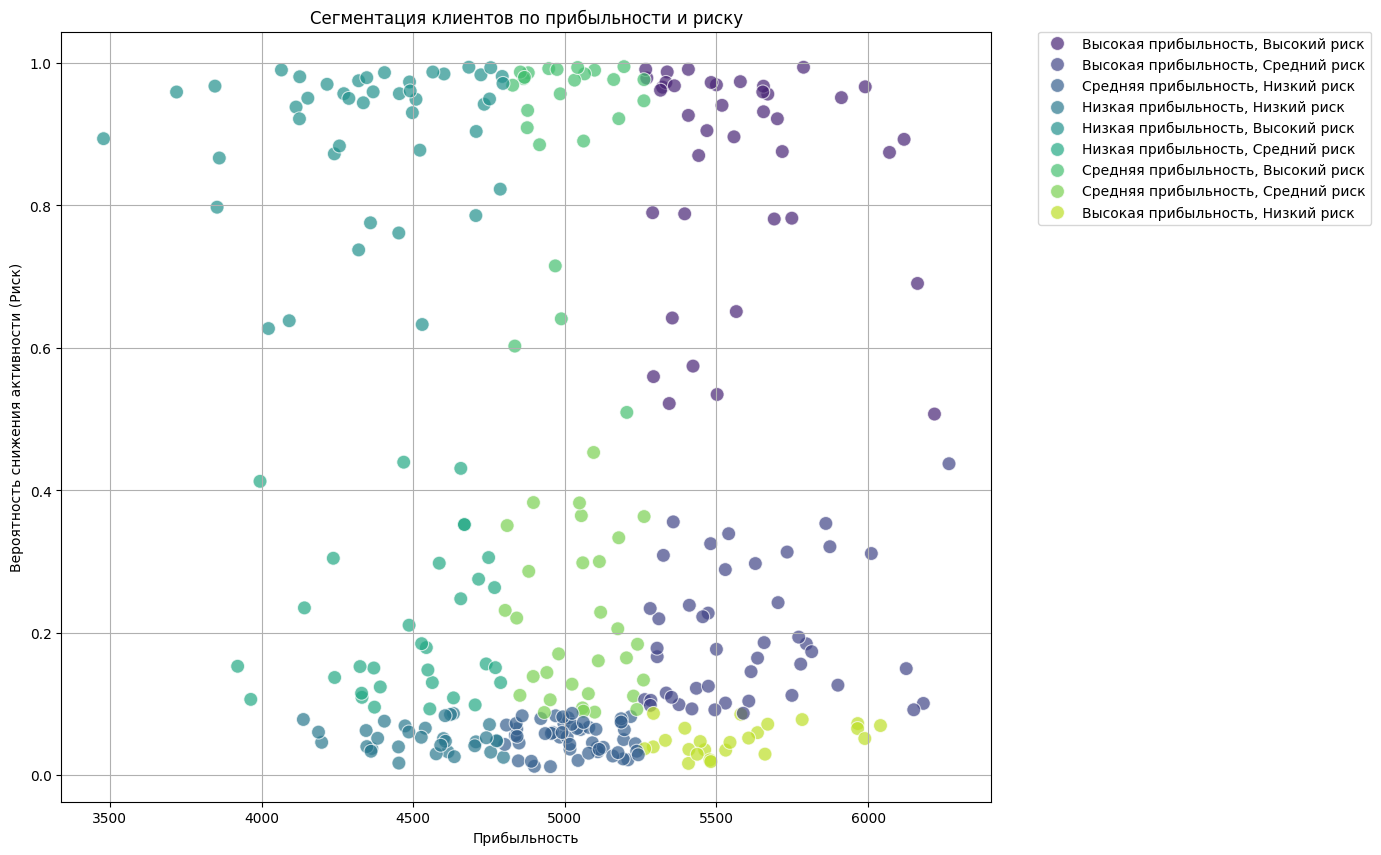

In [73]:
# изучаем средние значения ключевых признаков в каждом сегменте
print("\nСредние значения ключевых признаков по сегментам:")
segment_analysis = segmentation_df.groupby('final_segment')[['minutes_last_month', 'pages_per_visit', 'promo_share']].mean()
print(segment_analysis)

# создаем точечный график для визуализации сегментов
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=segmentation_df,
    x='profitability',
    y='prob_of_decrease',
    hue='final_segment',
    palette='viridis',
    s=100,  
    alpha=0.7 
)
plt.title('Сегментация клиентов по прибыльности и риску')
plt.xlabel('Прибыльность')
plt.ylabel('Вероятность снижения активности (Риск)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

Сравним два противоложных и наиболее интересных нам сегмента:

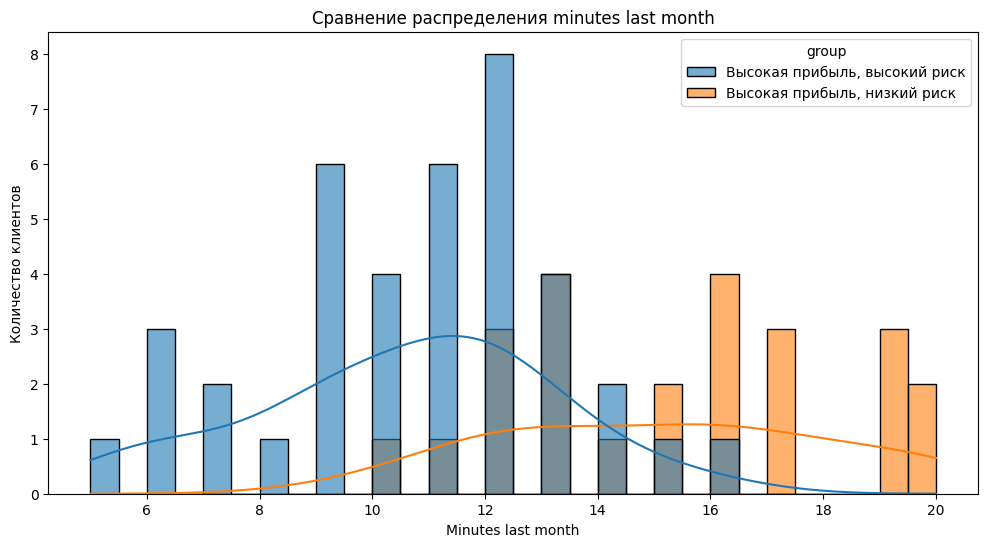

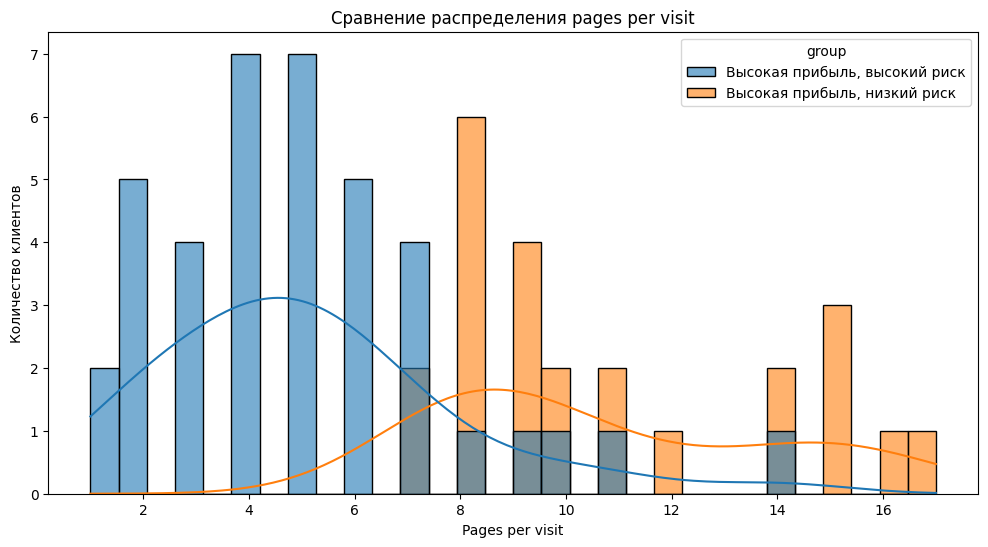

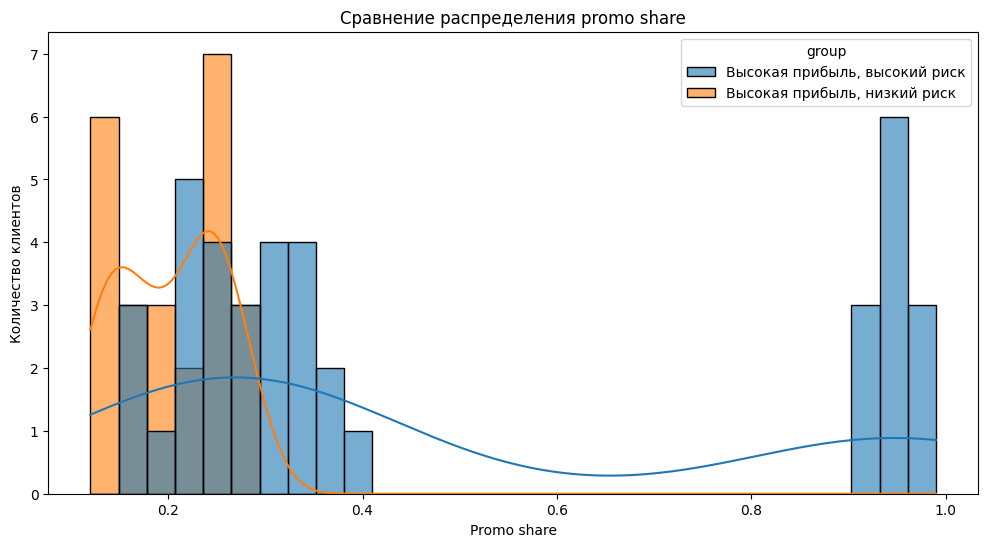

In [74]:
# выделяем целевой сегмент: "Высокая прибыльность, высокий риск"
target_segment = segmentation_df[
    segmentation_df['final_segment'] == 'Высокая прибыльность, Высокий риск'
]

# выделяем контр-сегмент: "Высокая прибыльность, низкий риск"
counter_segment = segmentation_df[
    segmentation_df['final_segment'] == 'Высокая прибыльность, Низкий риск'
]

# добавляем столбец для удобства сравнения
target_segment = target_segment.copy()
counter_segment = counter_segment.copy()
target_segment['group'] = 'Высокая прибыль, высокий риск'
counter_segment['group'] = 'Высокая прибыль, низкий риск'

# объединяем данные для графиков
comparison_df = pd.concat([target_segment, counter_segment])

# ключевые признаки для анализа
features_to_compare = ['minutes_last_month', 'pages_per_visit', 'promo_share']

# строим гистограммы для каждого признака
for feature in features_to_compare:
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=comparison_df,
        x=feature,
        hue='group',
        kde=True,
        bins=30,
        alpha=0.6
    )
    plt.title(f'Сравнение распределения {feature.replace("_", " ")}')
    plt.xlabel(feature.replace('_', ' ').capitalize())
    plt.ylabel('Количество клиентов')
    plt.show()

Анализ показывает, что различие между двумя группами с высокой прибыльностью заключается не в том, сколько они тратят, а в том, как они это делают. Клиенты, которые, как предсказывает модель, могут снизить свою активность, меньше вовлечены в контент сайта (меньше времени, меньше просмотренных страниц) и сильно мотивированы скидками. В то время как их лояльные высокоприбыльные "коллеги" проводят больше времени на сайте и меньше зависят от акций.

Дополнительно исследуем динамику выручки по месяцам с группировкой по популярным категориям товаров. Это может дать ценные инсайты для макретинговых предложений:

In [75]:
# объединим нужные данные
df_revenue_long = full_data_copy[['id', 'top_category']].copy()
df_revenue_long['revenue_prelast_month'] = full_data_copy['revenue_prelast_month']
df_revenue_long['revenue_last_month'] = full_data_copy['revenue_last_month']
df_revenue_long['revenue_current_month'] = full_data_copy['revenue_current_month']

# преобразуем данные
df_revenue_long = pd.melt(df_revenue_long, 
                          id_vars=['id', 'top_category'],
                          value_vars=['revenue_prelast_month', 
                                      'revenue_last_month', 
                                      'revenue_current_month'],
                          var_name='period', 
                          value_name='revenue')

# преобразуем 'period' для более удобного отображения
df_revenue_long['period'] = df_revenue_long['period'].str.replace('revenue_', '')

# проверим, что данные подготовлены
print(df_revenue_long.head())

       id       top_category         period  revenue
0  215349   Товары для детей  prelast_month   4472.0
1  215350  Домашний текстиль  prelast_month   4826.0
2  215351   Товары для детей  prelast_month   4793.0
3  215352   Товары для детей  prelast_month   4594.0
4  215353  Домашний текстиль  prelast_month   5124.0


In [76]:
# группируем по категории и периоду и считаем суммарную выручку
category_revenue_dynamics = df_revenue_long.groupby(['top_category', 'period'])['revenue'].sum().reset_index()

# проверяем, что группировка выполнена верно
print(category_revenue_dynamics.head())

             top_category         period    revenue
0       Домашний текстиль  current_month  1341309.4
1       Домашний текстиль     last_month  1273835.5
2       Домашний текстиль  prelast_month  1211765.0
3  Косметика и аксессуары  current_month  1199034.7
4  Косметика и аксессуары     last_month  1137351.0


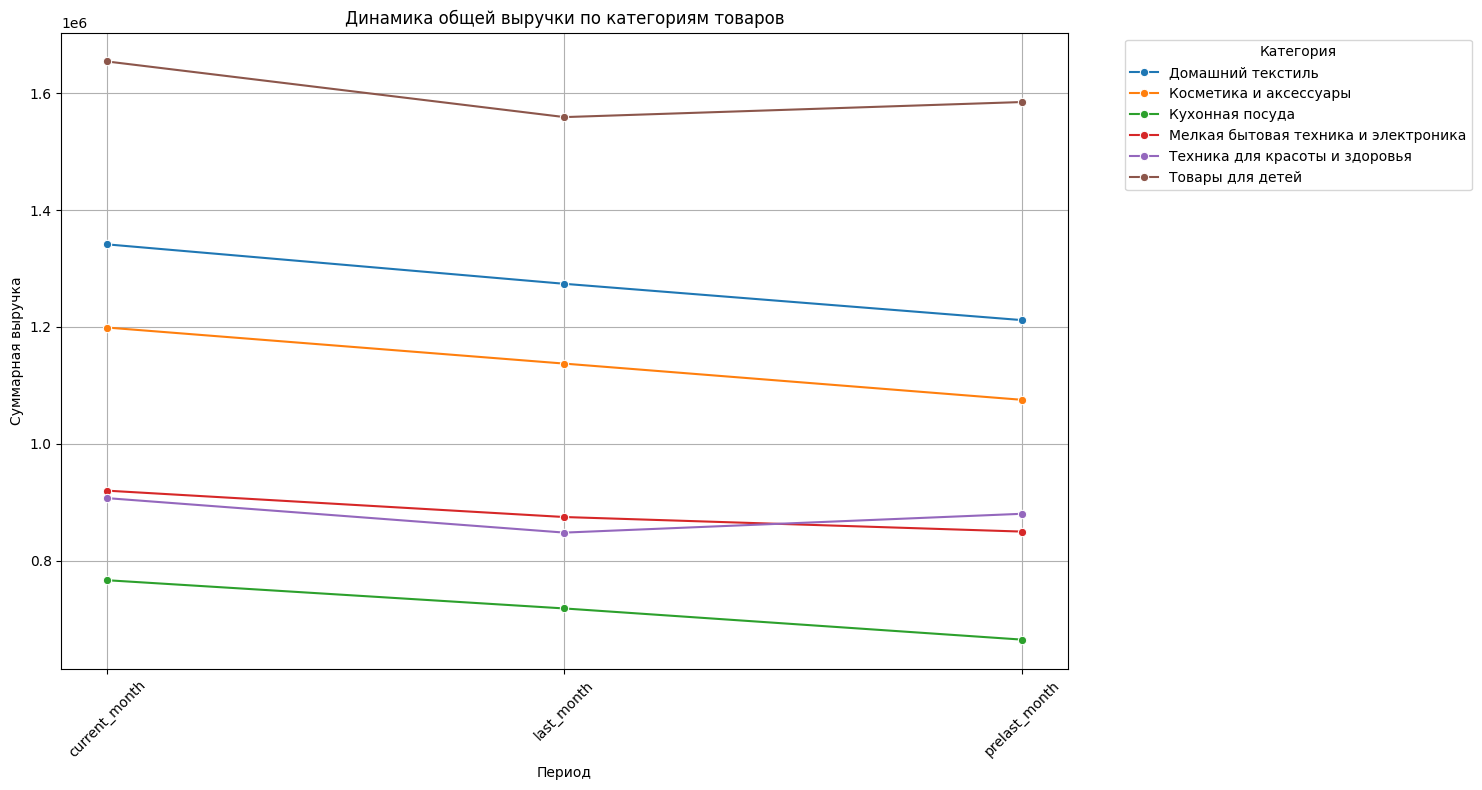

In [77]:
# построение линейного графика
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=category_revenue_dynamics,
    x='period',
    y='revenue',
    hue='top_category',
    marker='o')

plt.title('Динамика общей выручки по категориям товаров')
plt.xlabel('Период')
plt.ylabel('Суммарная выручка')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Категория', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

<div style="border: 2px solid black; padding: 10px;">
  <strong>Стратегия в работе с этими клиентами и не только:</strong>
  <ul>
    <li><strong>Улучшение вовлеченности:</strong> Поскольку эти клиенты проводят на сайте меньше времени, следует работать над повышением их вовлечённости. Можно создавать персонализированные подборки товаров, обзоры, статьи или видеоролики, чтобы они дольше оставались на платформе. Это может снизить вероятность их ухода.</li>
    <li><strong>Запуск персонализированной программы лояльности:</strong> Эти клиенты уже тратят много (avg_revenue), но их лояльность нестабильна. Эксклюзивные долгосрочные предложения, основанные на их истории покупок, помогут удержать их.</li>  
    <li><strong>Индивидуальные "триггерные" акции:</strong> Высокая доля покупок по акциям (promo_share) показывает, что клиенты чувствительны к ценовым стимулам. Вместо массовых скидок отправляйте персонализированные предложения на просмотренные, но не купленные товары. Это поможет стимулировать покупку, не снижая общую прибыльность.</li>
    <li><strong>Улучшение качества обслуживания:</strong> Почти половина сегмента — "премиум"-клиенты, что указывает на высокие ожидания. Инвестиции в приоритетную поддержку и персонализированное общение помогут удовлетворить их потребности и предотвратить уход.</li> 
    <li><strong>Работа с категориями товаров:</strong> Поддержка лидеров продаж и развитие наименее прибыльных категорий. Отдельно следует исследовать факторы, которые влияют на просадку и рост в выручке, использовать эту информацию для построения новых маркетинговых стратегий.</li>   
  </ul>
</div>

## Итоговые выводы

### Предобработка данных

- Изменены названия столбцов в датасетах;
- Устранены неявные дубликаты в категориальных столбцах;
- Пропуски в данных отсутствовали;
- Изменение типов данных не требовалось.

Этот этап позволил очистить данные и подготовить их к дальнейшему анализу.

### Исследовательский анализ данных

- Были проанализированы распределения признаков, также данные проверены на наличие выбросов.
- Критический выброс в признаке revenue (revenue_data) был обнаружен и удалён для обеспечения точности моделей.
- Выявлены потенциально важные для моделирования признаки.

### Корреляционный анализ

- Построена матрица корреляции по коэффициенту Phi, которая используется для анализа категориальных признаков, а также пар числовых-категориальных признаков.
- Построены диаграммы рассеяния для исследования характера корреляций.
- Были определены взаимосвязи между целевым и входными признаками, в том числе нелинейные.
- Выявлены наиболее полезные для моделей признаки, а также те, которые следует исключить при моделировании.
- Входные признаки проверены на наличие мультиколлинеарности и дублирования - они устранены.

### Использование пайплайнов

- Создание пайплайнов для предобработки данных и моделирования позволило стандартизировать процесс, сделать его воспроизводимым и избежать утечки данных.
- На основе кросс-валидации был выбран лучший алгоритм. Модель SVC показала лучшую метрику качества.
- На этапе EDA был выявлен дисбаланс целевой переменной. В связи с этим, для оценки качества модели была выбрана метрика F1-score, а не точность (accuracy).
- С помощью GridSearchCV были найдены оптимальные параметры для выбранной модели. Это позволило добиться наилучшей производительности модели.

### Анализ важности признаков

- Анализ важности признаков с помощью SHAP показал, что наиболее значимыми факторами, влияющими на покупательскую активность, являются поведенческие метрики: minutes_last_month, pages_per_visit и promo_share.
- Было выявлено как положительное, так и отрицательное влияние признаков. Высокие значения поведенческих метрик положительно влияют на сохранение активности, тогда как высокая доля покупок по акциям (promo_share) и отказ от промо (allow_promos) являются сильными индикаторами ее снижения.
- Для данного этапа была выбрана логистическая регрессия, так как она обеспечивает лучший баланс между качеством предсказания и интерпретируемостью. Это позволило наглядно объяснить, какие именно признаки и как влияют на итоговый прогноз.

### Сегментация покупателей

- Была использована методология, объединяющая прогнозный анализ (вероятность снижения активности) с финансовыми данными (прибыльность).
- Созданная матрица сегментации позволила выявить приоритетные группы для работы, в частности, сегмент «Высокая прибыльность, Высокий риск», который представляет наибольшую ценность для бизнеса, но находится в зоне потенциального оттока.
- Для целевого сегмента были разработаны персонализированные предложения, направленные на удержание и повышение лояльности. Они включают запуск программы лояльности, использование триггерных акций и улучшение качества обслуживания.

## Рекомендации заказчику

На основе проведенного анализа и разработанной модели предлагаются следующие рекомендации по работе с клиентской базой:

- **Внедрить предиктивную аналитику для раннего выявления риска.**

Интегрировать разработанную модель в рабочие процессы компании для регулярного (например, ежемесячного) прогнозирования вероятности снижения покупательской активности. Это позволит выявлять клиентов в зоне риска заранее, а не по факту оттока.

- **Сосредоточиться на сегменте «Высокая прибыльность, Высокий риск».**

Это самая ценная группа клиентов, которую необходимо удержать. Разработать и запустить для них персонализированные кампании, направленные на повышение лояльности и вовлеченности, а не просто на разовые скидки. Использовать индивидуальные предложения, основанные на их истории просмотров и покупок.

- **Использовать поведенческие метрики для принятия решений.**

Наши выводы показывают, что поведенческие метки, такие как время на сайте (minutes_last_month) и количество просмотренных страниц (pages_per_visit), являются наиболее важными предикторами. Рекомендуется отслеживать эти показатели, чтобы оперативно реагировать на изменения в поведении клиентов.

- **Сбалансировать промо-акции и лояльность.**

Анализ показал, что клиенты с высокой долей покупок по акциям (promo_share) более склонны к снижению активности. Следует оптимизировать промо-стратегию, чтобы она не формировала зависимость от скидок, а способствовала увеличению общей ценности клиента. Для этого можно, например, предлагать бонусы за покупки по полной цене или персонализированные предложения вместо массовых скидок.